# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
!pip install device-detector  # get usert-Agent info
!pip install geopy # find cities latitude and longitude
!pip install folium==0.13.0  # plot geographical map
!pip3 install wget

# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, col, desc, udf, when
from pyspark.sql.types import IntegerType, StringType, DoubleType
from pyspark.sql import Window
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import avg as Favg
import re
from functools import reduce

from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


import datetime
import time
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import folium
from geopy.geocoders import Nominatim
from folium.plugins import MarkerCluster
# Import folium MousePosition plugin
from folium.plugins import MousePosition
# Import folium DivIcon plugin
from folium.features import DivIcon


    100% |████████████████████████████████| 317kB 18.9MB/s ta 0:00:01
    100% |████████████████████████████████| 686kB 27.3MB/s ta 0:00:01
  Running setup.py bdist_wheel for device-detector ... done
  Stored in directory: /root/.cache/pip/wheels/75/11/3a/e5ace65af1e1ceceea84aaed59ec9f64d472776b8c0b659743
Successfully built device-detector
    100% |████████████████████████████████| 122kB 4.0MB/s ta 0:00:01
    100% |████████████████████████████████| 102kB 3.8MB/s a 0:00:011
  Running setup.py bdist_wheel for wget ... done
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [2]:
# create a Spark session
spark = SparkSession.builder.appName('SaprkifyCapstone').getOrCreate()

# 1. Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)

In [4]:
print('The initial number of rows is {} and number of column is {}:'.format(df.count(), len(df.columns)))
print('\nThe column names are:\n', df.persist(),)
print('\nThe first row is:\n', df.head())

The initial number of rows is 286500 and number of column is 18:

The column names are:
 DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

The first row is:
 Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')


**Let's clean the data set by removing the rows without any userId or sessionId:**

In [5]:
# drop Nan rows
df = df.dropna(how='any', subset=['userId', 'sessionId'])
print('The number of rows after removing Nans is {}:'.format(df.count()))

# check the userId values
df.select('userId').dropDuplicates().sort('userId').show()

# Remove rows that have empty userId
df = df.filter(df['userId'] != '')
print('The number of rows after removing empty userIds is {}'.format(df.count()))

The number of rows after removing Nans is 286500:
+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows

The number of rows after removing empty userIds is 278154


We can see that 8346 (286500-278154=8346) rows do not have any userId. 

**Let's take a look at null values at each column:**

In [6]:
print('Number of Null values in each column are:')
for col_name in df.columns:
    print(col_name, ': ', df.filter(col(col_name).isNull()).count())

Number of Null values in each column are:
artist :  50046
auth :  0
firstName :  0
gender :  0
itemInSession :  0
lastName :  0
length :  50046
level :  0
location :  0
method :  0
page :  0
registration :  0
sessionId :  0
song :  50046
status :  0
ts :  0
userAgent :  0
userId :  0


Only three columns ("artist", "length", "song") has missing values and they have equal number of missing values.

**So, let's check if these missing values are all for the same rows.**

In [7]:
df.select('userId', 'artist', 'length', 'song')\
    .where((col('artist').isNull()==True) & 
           (col('length').isNull()==True) & 
           (col('song').isNull()==True))\
    .count()

50046

Therefore, the 50046 missing values are all for the same rows. Removing 50046 is not a good practice since significant amount of useful data will be lost. These missing value rows should be kept, however, we will need to impute them.

**For these missing vales the "length" column is replaced with the average of each user, the "song" and "artist" columns will be replaced with "Unknown". ("valid" is added to these column names and the original columns are removed)**

In [8]:
print('Number of Null values in each column are (after cleaning):')
for col_name in df.columns:
    print(col_name, ': ', df.filter(col(col_name).isNull()).count())

Number of Null values in each column are (after cleaning):
artist :  50046
auth :  0
firstName :  0
gender :  0
itemInSession :  0
lastName :  0
length :  50046
level :  0
location :  0
method :  0
page :  0
registration :  0
sessionId :  0
song :  50046
status :  0
ts :  0
userAgent :  0
userId :  0


So far, we replaced the null values for song, artist, and length columns (and changed their column names and removed them)

**The dataset is clean now**

# 2. Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

#### First, different columns are explored without considering the churn and active users. Later, the dataset will be explored with considering the churn and active users.

In [9]:
print('Total number of users is:')
print(df.select("userId").dropDuplicates().sort("userId").count())

print('\nUnique values of "auth" column are:')
df.groupBy("auth").count().orderBy(['count'],  ascending = [False]).show()

print('\nUnique values of "gender" column are:')
df.groupBy("gender").count().orderBy(['count'],  ascending = [False]).show()

print('\nUnique values of "itemInSession" column are (first 5):')
df.groupBy("itemInSession").count().orderBy(['count'],  ascending = [False]).show(5)

print('\nThe number of free and paid events are:')
df.groupBy("level").count().orderBy(['count'],  ascending = [False]).show()

print('\nThe number of locations are (first 10):')
df.groupBy("location").count().orderBy(['count'],  ascending = [False]).show(10, truncate=False)

print('\nThe number of "methods" are:')
df.groupBy("method").count().orderBy(['count'],  ascending = [False]).show()

print('\nUnique values of "page" column are:')
df.groupBy("page").count().orderBy(['count'],  ascending = [False]).show(truncate=False)

print('\nUnique values of "registration" column are (first 5):')
df.groupBy("registration").count().orderBy(['count'],  ascending = [False]).show(5)

print('\nUnique values of "sessionId" column are (first 5):')
df.groupBy("sessionId").count().orderBy(['count'],  ascending = [False]).show(5)

print('\nUnique values of "status" column are:')
df.groupBy("status").count().orderBy(['count'],  ascending = [False]).show()

print('\nUnique values of "userAgent" column are (first 5):')
df.groupBy("userAgent").count().orderBy(['count'],  ascending = [False]).show(5, truncate=False)

print('\nUnique values of "userId" column are (first 5):')
df.groupBy("userId").count().orderBy(['count'],  ascending = [False]).show(5)

print('\nUnique values of "artist" column are (first 5):')
df.groupBy("artist").count().orderBy(['count'],  ascending = [False]).show(5)

print('\nUnique values of "artist" column are (first 5):')
df.groupBy("artist").count().orderBy(['count'], ascending=[False]).show(5)

print('\nUnique values of "song" column are (first 5):')
df.groupBy("song").count().orderBy(['count'], ascending=[False]).show(5)


Total number of users is:
225

Unique values of "auth" column are:
+---------+------+
|     auth| count|
+---------+------+
|Logged In|278102|
|Cancelled|    52|
+---------+------+


Unique values of "gender" column are:
+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
+------+------+


Unique values of "itemInSession" column are (first 5):
+-------------+-----+
|itemInSession|count|
+-------------+-----+
|            2| 2941|
|            3| 2917|
|            4| 2887|
|            5| 2836|
|            1| 2818|
+-------------+-----+
only showing top 5 rows


The number of free and paid events are:
+-----+------+
|level| count|
+-----+------+
| paid|222433|
| free| 55721|
+-----+------+


The number of locations are (first 10):
+-------------------------------------------+-----+
|location                                   |count|
+-------------------------------------------+-----+
|Los Angeles-Long Beach-Anaheim, CA         |30131|
|New York-Newark-Jerse

### 2.1. Define new columns:
* **churn** : if user sent "Cancellation Confirmation" on the page column ==> 1  else 0


* **downgraded** : if user sent "Submit Downgrade" on the page column ==> 1  else 0
* **phase**: if user does not "Submit Downgrade" ==> 1 else 0



* **registration_date**: date of registration in '%Y-%m-%d %H:%M:%S' format


* **ts_date**: date of "ts" in '%Y-%m-%d %H:%M:%S' format 
* **ts_days_registration**: number of days elapsed from ts to the registration date
* **hour**: The hour of the timestamp "ts"
* **day**: The day of the month for the timestamp "ts"
* **weekday**: The weekday of the timestamp "ts" (0=Minday, 1=Tuesday, ...)
* **month**: The month of the timestamp "ts"
* **year**: The year of the timestamp "ts"


* **userAgent_browser**: The browser (Chrome, FireFox, etc.) from the "userAgent"
* **userAgent_OS**: The operating system (Windows, iOS, etc.) from the "userAgent"
* **userAgent_deviceType**: The device type (smartphone, deshtop, etc.) from the "userAgent"


* **city**: city of the location
* **city_5** : if city is in the list of 5 most popular cities then keep it, otherwise "null"
* **state**: state of the location
* **state_5** : if state is in the list of 5 most popular states then keep it, otherwise "null"


* **song_100** : if song is in the most_streamed_songs100 then keep it, otherwise "null"
* **artist_5** : if artist is in the list 5 most popular artist then keep it, otherwise "null"

Define churn colum:

In [10]:
## define "churn" column
get_churn = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0)
df = df.withColumn("churn", get_churn("page").cast("int"))

In [11]:
df.groupBy("churn").count().orderBy(['count'], ascending=[False]).show()

+-----+------+
|churn| count|
+-----+------+
|    0|278102|
|    1|    52|
+-----+------+



Define "downgraded" and phase columns

In [12]:
## define "downgraded" and "phase" columns
get_downgrade = udf(lambda x: 1 if x == "Submit Downgrade" else 0)
df = df.withColumn("downgraded", get_downgrade("page").cast("int"))

windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
df = df.withColumn("phase", Fsum("downgraded").over(windowval))

In [13]:
df.groupBy("downgraded").count().orderBy(['count'], ascending=[False]).show()

+----------+------+
|downgraded| count|
+----------+------+
|         0|278091|
|         1|    63|
+----------+------+



Define registration_date column

In [14]:
## Define registration_date column
get_registration_date = udf(lambda x: datetime.datetime.utcfromtimestamp(int(x)/1000.).strftime('%Y-%m-%d %H:%M:%S'))
df = df.withColumn("registration_date", get_registration_date(df.registration)) # date of registration

In [15]:
df.groupBy("registration_date").count().orderBy(['count'], ascending=[False]).show(5)

+-------------------+-----+
|  registration_date|count|
+-------------------+-----+
|2018-06-15 01:52:21| 9632|
|2018-09-08 10:52:52| 7230|
|2018-09-11 05:01:49| 6880|
|2018-09-30 19:46:11| 5732|
|2018-07-22 01:52:15| 4825|
+-------------------+-----+
only showing top 5 rows



Define ts_date, hour, day of month, day of week, month, year, and ts_days_registration (days elapsed from the registration) columns

In [16]:
# define ts_date (date of ts)
get_ts_date = udf(lambda x: datetime.datetime.utcfromtimestamp(int(x)/1000.).strftime('%Y-%m-%d %H:%M:%S'))
df = df.withColumn("ts_date", get_ts_date(df.ts))

# define hour
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
df = df.withColumn("hour", get_hour(df.ts).cast(IntegerType()))

# define day of month
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
df = df.withColumn("day", get_day(df.ts).cast(IntegerType()))

# define month
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month)
df = df.withColumn("month", get_month(df.ts).cast(IntegerType()))

# define year
get_year = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).year)
df = df.withColumn("year", get_year(df.ts).cast(IntegerType()))

# Define day of week
get_weekdays = udf(lambda x: datetime.datetime.weekday(datetime.datetime.strptime(datetime.datetime.utcfromtimestamp(int(x)/1000.0).strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')))
df = df.withColumn("weekday", get_weekdays(df.ts).cast(IntegerType()))

# define ts_days_registration (days elapsed from the registration)
def get_days_from_registration(ts_date, reg_date):
    """
    Function to calculate the elapsed time (in day) 
    from the registration time to the ts_time
    Input: 
        ts_date: date of ts (string)
        reg_date: date of registration (string)
    Ouput: Elapsed time in days (String)
    """
    d1 = datetime.datetime.strptime(str(reg_date), '%Y-%m-%d %H:%M:%S')
    d2 = datetime.datetime.strptime(str(ts_date), '%Y-%m-%d %H:%M:%S')
    delta = d2 - d1
    return delta.days

# Define ts_days_registration column
get_days_from_registration_UDF = udf(lambda ts_date, reg_date: get_days_from_registration(ts_date,  reg_date), IntegerType())
df = df.withColumn("ts_days_registration", get_days_from_registration_UDF("ts_date", "registration_date"))

In [17]:
df.groupBy("ts_date").count().orderBy(['count'], ascending=[False]).show(5)
df.groupBy("hour").count().orderBy(['count'], ascending=[False]).show(5)
df.groupBy("day").count().orderBy(['count'], ascending=[False]).show(5)
df.groupBy("weekday").count().orderBy(['count'], ascending=[False]).show()
df.groupBy("month").count().orderBy(['count'], ascending=[False]).show()
df.groupBy("year").count().orderBy(['count'], ascending=[False]).show()
df.groupBy("ts_days_registration").count().orderBy(['count'], ascending=[False]).show(5)

+-------------------+-----+
|            ts_date|count|
+-------------------+-----+
|2018-11-28 03:43:28|    4|
|2018-10-06 00:35:40|    4|
|2018-11-13 04:19:09|    3|
|2018-10-12 18:10:33|    3|
|2018-10-18 09:43:09|    3|
+-------------------+-----+
only showing top 5 rows

+----+-----+
|hour|count|
+----+-----+
|  16|14297|
|  17|14082|
|  15|13936|
|  18|13599|
|  19|13366|
+----+-----+
only showing top 5 rows

+---+-----+
|day|count|
+---+-----+
|  2|11843|
|  1|11298|
|  9|11292|
| 16|11007|
| 30|10964|
+---+-----+
only showing top 5 rows

+-------+-----+
|weekday|count|
+-------+-----+
|      4|48173|
|      1|47364|
|      2|45968|
|      3|44320|
|      0|43252|
|      5|28027|
|      6|21050|
+-------+-----+

+-----+------+
|month| count|
+-----+------+
|   10|144916|
|   11|133234|
|   12|     4|
+-----+------+

+----+------+
|year| count|
+----+------+
|2018|278154|
+----+------+

+--------------------+-----+
|ts_days_registration|count|
+--------------------+-----+
|      

Defining the operating system, browser, and device type from the "userAgent" string:

In [18]:
# DeviceDetector is a user agent parser and device detector written in Python
# It is used to get the operating system, device ttype and browser from the userAgent string
from device_detector import DeviceDetector

def get_userAgent_OS(x):
    """
    Function to get the operating system from user Agent string
    Input: user Agent string (String)
    Ouput: operating system (String)
    """
    try:
        device = DeviceDetector(x).parse()
        return device.os_name()
    except:
        return "Other"


def get_userAgent_browser(x):
    """
    Function to get the browser type from user Agent string
    Input: user Agent string (String)
    Ouput: browser (String)
    """
    try:
        device = DeviceDetector(x).parse()
        return device.client_name()
    except:
        return "Other"
    

def get_userAgent_deviceType(x):
    """
    Function to get the device type from user Agent string
    Input: user Agent string (String)
    Ouput: device type (String)
    """
    try:
        device = DeviceDetector(x).parse()
        return device.device_type()
    except:
        return "Other"

# Define browser column
get_userAgent_browser_UDF = udf(lambda z: get_userAgent_browser(z), StringType())
df = df.withColumn("userAgent_browser", get_userAgent_browser_UDF("userAgent"))

# Define device type column
get_userAgent_deviceType_UDF = udf(lambda z: get_userAgent_deviceType(z), StringType())
df = df.withColumn("userAgent_deviceType", get_userAgent_deviceType_UDF("userAgent"))

# Define operating system column
get_userAgent_OS_UDF = udf(lambda z: get_userAgent_OS(z), StringType())
df = df.withColumn("userAgent_OS", get_userAgent_OS_UDF("userAgent"))

In [19]:
df.groupBy("userAgent_browser").count().orderBy(['count'],  ascending = [False]).show()
df.groupBy("userAgent_OS").count().orderBy(['count'],  ascending = [False]).show()
df.groupBy("userAgent_deviceType").count().orderBy(['count'],  ascending = [False]).show()

+-----------------+------+
|userAgent_browser| count|
+-----------------+------+
|           Chrome|145591|
|          Firefox| 55646|
|           Safari| 38997|
|    Mobile Safari| 22573|
|Internet Explorer| 15347|
+-----------------+------+

+------------+------+
|userAgent_OS| count|
+------------+------+
|     Windows|143871|
|         Mac|102749|
|         iOS| 22573|
|   GNU/Linux|  7025|
|      Ubuntu|  1936|
+------------+------+

+--------------------+------+
|userAgent_deviceType| count|
+--------------------+------+
|             desktop|255581|
|              tablet| 11381|
|          smartphone| 11192|
+--------------------+------+



Defining city and state columns

In [20]:
# Define city column
get_location_city = udf(lambda x: x.split(',')[0], StringType())
df = df.withColumn("city", get_location_city("location"))

# Define state column
get_location_state = udf(lambda x: x.split(',')[1], StringType())
df = df.withColumn("state", get_location_state("location"))

In [21]:
df.groupBy("city").count().orderBy(['count'], ascending=[False]).show(5, truncate=False)
df.groupBy("state").count().orderBy(['count'], ascending=[False]).show(5)

+--------------------------------+-----+
|city                            |count|
+--------------------------------+-----+
|Los Angeles-Long Beach-Anaheim  |30131|
|New York-Newark-Jersey City     |23684|
|Boston-Cambridge-Newton         |13873|
|Houston-The Woodlands-Sugar Land|9499 |
|Charlotte-Concord-Gastonia      |7780 |
+--------------------------------+-----+
only showing top 5 rows

+---------+-----+
|    state|count|
+---------+-----+
|       CA|46771|
| NY-NJ-PA|23684|
|       TX|23494|
|    MA-NH|13873|
|       FL|13190|
+---------+-----+
only showing top 5 rows



Define the 5 most popular cities and states

In [22]:
# List of all the cities
most_popular_cities = df.groupBy("city").count().orderBy(['count'], ascending=[False]).select('city').rdd.flatMap(lambda x: x).collect()

# list of the 5 most popularcities
most_popular_cities5 = most_popular_cities[0:5] # remove the first song which is None

# define  new column where cities that are not in the 5 most popular cities will be replaces with null
get_city_5 = udf(lambda x: x if x in most_popular_cities5 else None)
df = df.withColumn("city_5", get_city_5(df.city))



# List of all the states
most_popular_states = df.groupBy("state").count().orderBy(['count'], ascending=[False]).select('state').rdd.flatMap(lambda x: x).collect()

# list of the 5 most popular states
most_popular_states5 = most_popular_states[0:5] # remove the first song which is None

# define  new column where states that are not in the 5 most popular states will be replaces with null
get_state_5 = udf(lambda x: x if x in most_popular_states5 else None)
df = df.withColumn("state_5", get_state_5(df.state))



## See how many cities are in the 5 most popular cities
num_cities_in_5 = df.filter(col('city_5').isNotNull()).count()
tot_num_cities = df.select('userId').count()
perc_city_5 = num_cities_in_5/tot_num_cities*100.
print('Number of cities that are in the 5 most popular cities list are %d out of %d totl number of rows (%.2f%%):'\
      % (num_cities_in_5, tot_num_cities, perc_city_5))


## See how many states are in the 5 most popular cities
num_states_in_5 = df.filter(col('state_5').isNotNull()).count()
tot_num_states = df.select('userId').count()
perc_state_5 = num_states_in_5/tot_num_states*100.
print('Number of states that are in the 5 most popular staes list are %d out of %d totl number of rows (%.2f%%):'\
      % (num_states_in_5, tot_num_states, perc_state_5))

Number of cities that are in the 5 most popular cities list are 84967 out of 278154 totl number of rows (30.55%):
Number of states that are in the 5 most popular staes list are 121012 out of 278154 totl number of rows (43.51%):


Defining the 100 most streamed songs:

In [23]:
# List of all the songs sorted by count
most_streamed_songs = df.groupBy("song").count().orderBy(['count'], ascending=[False]).select('song').rdd.flatMap(lambda x: x).collect()

# list of the 100 most streamed songs
most_streamed_songs100 = most_streamed_songs[1:101] # remove the first song which is None

# define a new column where songs that are not in the 100 most streamed songs
# will be replaces with null
get_song_100 = udf(lambda x: 1 if x in most_streamed_songs100 else None)
df = df.withColumn("song_100", get_song_100(df.song))
df.select('song_100').show(5)

# df_song_pd = df.select("song").toPandas()

+--------+
|song_100|
+--------+
|    null|
|       1|
|    null|
|    null|
|    null|
+--------+
only showing top 5 rows



In [24]:
## See how many songs are in the 100 most streamed songs
num_songs_in_100 = df.filter(col('song_100').isNotNull()).count()
tot_num_songs = df.select('song_100').count()
perc_song_100 = num_songs_in_100/tot_num_songs*100.
print('Number of songs that are in the 100 most streamed songs list are %d out of %d rows(%.2f%%):'\
      % (num_songs_in_100, tot_num_songs, perc_song_100))

Number of songs that are in the 100 most streamed songs list are 23380 out of 278154 rows(8.41%):


Defining the 5 most popular artist:

In [25]:
##List of all the artistss sorted by count
most_streamed_artist = df.groupBy("artist").count().orderBy(['count'], ascending=[False]).select('artist').rdd.flatMap(lambda x: x).collect()

# list of the 5 most streamed artist
most_streamed_artist5 = most_streamed_artist[1:6] # remove the first artist which is None

# define a new column where artist that are not in the 5 most streamed artist
# will be replaces with null
get_artist_5 = udf(lambda x: 1 if x in most_streamed_artist5 else None)
df = df.withColumn("artist_5", get_artist_5(df.artist))
df.select('artist_5').show(5)

# df_song_pd = df.select("song").toPandas()

+--------+
|artist_5|
+--------+
|    null|
|    null|
|    null|
|    null|
|    null|
+--------+
only showing top 5 rows



In [26]:
## See how many artist are in the 5 most streamed artist
num_artist_in_5 = df.filter(col('artist_5').isNotNull()).count()
tot_num_artist = df.select('artist_5').count()
perc_artist_5 = num_artist_in_5/tot_num_artist*100.
print('Number of artist that are in the 5 most streamed songs list are %d out of %d rows(%.2f%%):'\
      % (num_artist_in_5, tot_num_artist, perc_artist_5))


Number of artist that are in the 5 most streamed songs list are 7158 out of 278154 rows(2.57%):


### 2.2. Comparison Between Behavior of Churn and Active Users

Effect of each column (feature) on the churn and active users will be analyzed through visualization.

Firstly, let's define dataframes for churn users (churn=1) and active users (churn=0)

In [27]:
# Define the list of churn users
churned_users = df.select("userId").where(df.churn==1).rdd.flatMap(lambda x: x).collect()

# add a column for churn users (delete it later)
df = df.withColumn('churned_user', df.userId.isin(churned_users))

df_churn1 = df.select("*").where(df.churned_user==True)
df_churn0 = df.select("*").where(df.churned_user==False)

#### 2.2.1. Variations of "auth" for active and churn users:

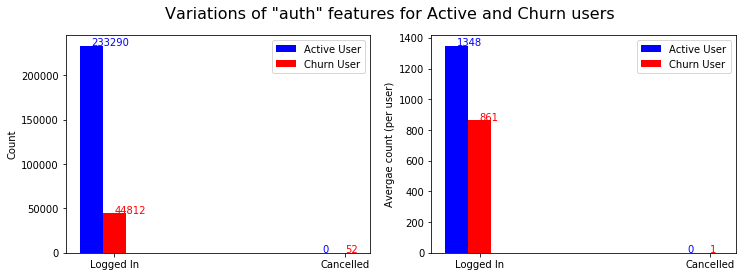

In [28]:
# to compute in logarithmic scale
from math import log

def plot_auth(df_churn0, df_churn1):
    """
    This function plots the count of "auth" column values for the churn and active users
    input:
        df_churn0: Dataframe of active users (df.churn==0)
        df_churn1: Dataframe of churn users (df.churn==1)
        
    Output: none (2 sub-figures)
    """
    
    # Number of churn and active users
    n0 = df_churn0.select("userId").dropDuplicates().count()*1.0
    n1 = df_churn1.select("userId").dropDuplicates().count()*1.0
    
    #  Calculate count of "auth" column for active and churn users
    ch0 = df_churn0.groupBy("auth").count().orderBy(['count'],ascending=[False]).toPandas()
    ch1 = df_churn1.groupBy("auth").count().orderBy(['count'],ascending=[False]).toPandas()
    
    # convert to list for plotting
    ch1 = ch1['count'].tolist()
    ch0 = ch0['count'].tolist()
    
    ch1_avg = [x/n1 for x in ch1]
    ch0_avg = [x/n0 for x in ch0]
    
    ch0_avg.append(0) # since active users (ch0) does not have "Cancelled" event, 0 is added
    ch0.append(0) # since active users (ch0) does not have "Cancelled" event, 0 is added
    
    
    # plot
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))
    fig.suptitle('Variations of "auth" features for Active and Churn users', fontsize=16)

    barWidth = 0.1
    # Set position of bar on X axis
    br1 = np.arange(len(ch1))
    br2 = [x + barWidth for x in br1]

    # subplot 1
    axs[0].bar(br1, ch0, color ='b', width = barWidth, label ='Active User')
    axs[0].bar(br2, ch1, color ='r', width = barWidth, label ='Churn User')
    axs[0].set_ylabel('Count', fontsize = 10)
    axs[0].set_xticks([r + barWidth for r in range(len(ch1))])
    axs[0].set_xticklabels(['Logged In', 'Cancelled'])
    axs[0].legend(loc='best')
    # Add text values
    for i, v in enumerate(ch0):
        axs[0].text(i , v , str(v), color = 'blue')
    for i, v in enumerate(ch1):
        axs[0].text(i+0.1 , v , str(v), color = 'red')
            
            
    # subplot 2
    axs[1].bar(br1, ch0_avg, color ='b', width = barWidth, label ='Active User')
    axs[1].bar(br2, ch1_avg, color ='r', width = barWidth, label ='Churn User')
    axs[1].set_ylabel('Avergae count (per user)', fontsize = 10)
    axs[1].set_xticks([r + barWidth for r in range(len(ch1))])
    axs[1].set_xticklabels(['Logged In', 'Cancelled'])
    axs[1].legend(loc='best')
    # Add text values
    for i, v in enumerate(ch0_avg):
        axs[1].text(i , v , str(int(v)), color = 'blue')
    for i, v in enumerate(ch1_avg):
        axs[1].text(i+0.1 , v , str(int(v)), color = 'red')
    
    plt.show()

plot_auth(df_churn0, df_churn1)

It should be noted all of the users's activities such as visiting different pages are recorded when the user logs-in. So, using the count of "auth" is not an appropriate feature to predict churn.

#### 2.2.2. Variations of "gender" for active and churn users:

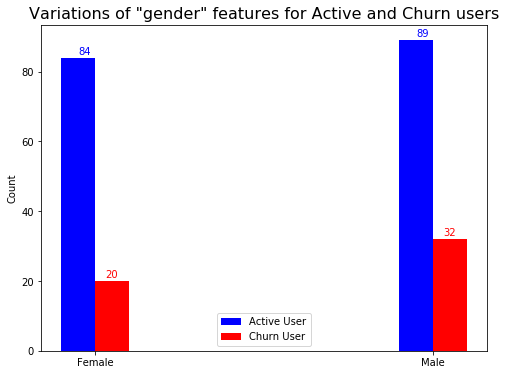

In [29]:
def plot_gender(df_churn0, df_churn1):
    """
    This function plots the count of "gender" column values for the churn and active users
    input:
        df_churn0: Dataframe of active users (df.churn==0)
        df_churn1: Dataframe of churn users (df.churn==1)
        
    Output: none (a figure)
    """
    
    #  Calculate count of "gender" column for active and churn users
    ch0 = df_churn0.select("userId", 'gender').dropDuplicates(['userId']).groupBy("gender").count().toPandas()
    ch1 = df_churn1.select("userId", 'gender').dropDuplicates(['userId']).groupBy("gender").count().toPandas()
    
    # convert to list for plotting
    ch1_count = ch1['count'].tolist()
    ch0_count = ch0['count'].tolist()
    
    # plot
    barWidth = 0.1
    # Set position of bar on X axis
    br1 = np.arange(len(ch1_count))
    br2 = [x + barWidth for x in br1]

    fig = plt.figure(figsize=(8, 6))
    plt.title('Variations of "gender" features for Active and Churn users', fontsize=16)
    plt.bar(br1, ch0_count, color ='b', width = barWidth, label ='Active User')
    plt.bar(br2, ch1_count, color ='r', width = barWidth, label ='Churn User')
    plt.ylabel('Count', fontsize = 10)
    plt.xticks([r+barWidth/2 for r in range(len(ch1))], ['Female', 'Male'])
    plt.legend(loc='best')
    # Add text values
    for i, v in enumerate(ch0_count):
        plt.text(i , v+1 , str(v), color = 'blue')
    for i, v in enumerate(ch1_count):
        plt.text(i+0.08 , v+1 , str(v), color = 'red')
    
    plt.show()

    
plot_gender(df_churn0, df_churn1)

For the active users we can see that the number of female and male users are very close to each other. However, for the churn users, there are more male users than female. Gender will be considered as a feature for modeling.

#### 2.2.3. Variations of "itemInSession" for active and churn users:

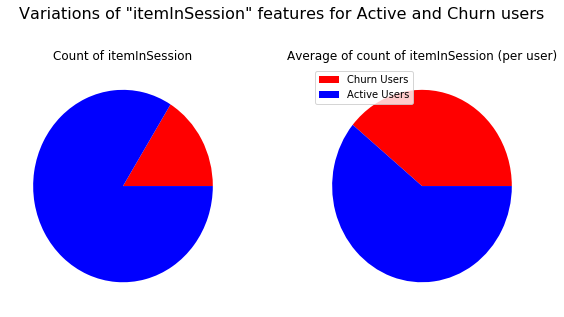

In [30]:
def plot_itemInSession(df_churn0, df_churn1):
    """
    This function plots the sum of "itemInSession" column values for the churn and active users
    input:
        df_churn0: Dataframe of active users (df.churn==0)
        df_churn1: Dataframe of churn users (df.churn==1)
        
    Output: none (2 sub-figures)
    """
    
    # Number of churn and active users
    n0 = df_churn0.select("userId").dropDuplicates().count()*1.0
    n1 = df_churn1.select("userId").dropDuplicates().count()*1.0
    
    #  Calculate sum of "itemInSession" column for active and churn users
    ch0 = df_churn0.agg(count('itemInSession').alias('count')).toPandas()
    ch1 = df_churn1.agg(count('itemInSession').alias('count')).toPandas()

    # convert to list for plotting
    ch1_count = ch1['count'].tolist()
    ch0_count = ch0['count'].tolist()
    
    ch1_avg = [x/n1 for x in ch1_count]
    ch0_avg = [x/n0 for x in ch0_count]
     
    item_count = [ch1_count, ch0_count]
    item_avg = [ch1_avg, ch0_avg]
    
    
    # plot
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(9, 5))
    fig.suptitle('Variations of "itemInSession" features for Active and Churn users', fontsize=16)

    axs[0].pie(item_count, colors = ['r', 'b'], labels = ['', ''])
    axs[0].title.set_text('Count of itemInSession')
    
    axs[1].pie(item_avg, colors = ['r', 'b'], labels = ['', ''])
    axs[1].title.set_text('Average of count of itemInSession (per user)')
    
    plt.legend(labels=["Churn Users", "Active Users"], loc='upper left')
    fig.tight_layout(pad=5.0)
    plt.show()

plot_itemInSession(df_churn0, df_churn1)

In [31]:
# calculate correlation 
df.stat.corr("churn", "itemInSession")

-0.0028123911118732975

From the above figure, it can be seen that the total number of itemInSession is smaller for churn user, however, its impact is slightly noticeable. The correlation between churn and itemInSession is ~-0.003, which is pretty much small. Despite this, total number of itemInSession will be considered as a feature for modeling.

#### 2.2.4. Variations of "length" for active and churn users:

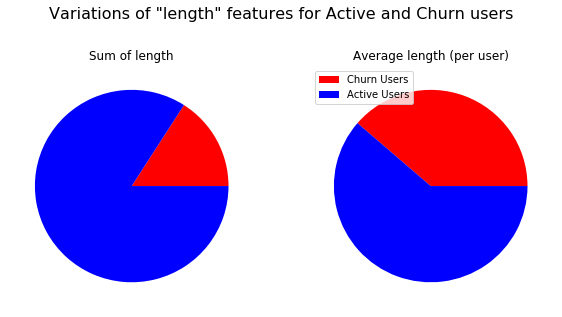

In [32]:
def plot_length(df_churn0, df_churn1):
    """
    This function plots the sum of "length" column values for the churn and active users
    input:
        df_churn0: Dataframe of active users (df.churn==0)
        df_churn1: Dataframe of churn users (df.churn==1)
        
    Output: none (2 sub-figures)
    """
    
    # Number of churn and active users
    n0 = df_churn0.select("userId").dropDuplicates().count()*1.0
    n1 = df_churn1.select("userId").dropDuplicates().count()*1.0
    
    #  Calculate sum of "itemInSession" column for active and churn users
    ch0 = df_churn0.agg(Fsum('length').alias('sum')).toPandas()
    ch1 = df_churn1.agg(Fsum('length').alias('sum')).toPandas()
    # convert to list for plotting
    ch1_sum = ch1['sum'].tolist()
    ch0_sum = ch0['sum'].tolist()
    # Calculate the average
    ch1_avg = ch1_sum[0]/n1
    ch0_avg = ch0_sum[0]/n0
    
    # put in a list for plotting
    item_count = [ch1_sum, ch0_sum]
    item_avg = [ch1_avg, ch0_avg]

    
    # plot
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(9, 5))
    fig.suptitle('Variations of "length" features for Active and Churn users', fontsize=16)

    axs[0].pie(item_count, colors = ['r', 'b'], labels = ['', ''])
    axs[0].title.set_text('Sum of length')
    
    axs[1].pie(item_avg, colors = ['r', 'b'], labels = ['', ''])
    axs[1].title.set_text('Average length (per user)')
    
    plt.legend(labels=["Churn Users", "Active Users"], loc='upper left')
    fig.tight_layout(pad=5.0)
    plt.show()
    
plot_length(df_churn0, df_churn1)

In [33]:
# calculate correlation 
df.stat.corr("churn", "length")

-0.02128053533022869

It can be seen that the sum of the length is larger for active users. The correlation between churn and length is ~-0.02. We will consider length as a feature for modeling.

#### 2.2.5. Variations of "level" for active and churn users:

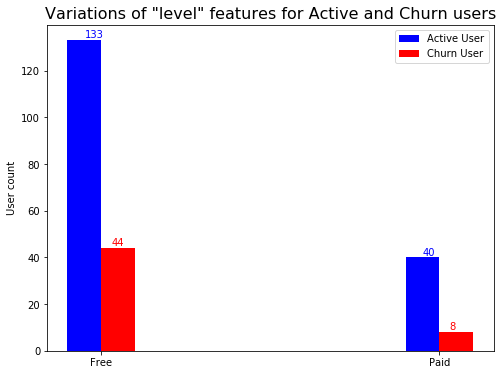


Percentage of free-level users in churn group is 76.88% and for active group it is 84.62%


In [34]:
def plot_level(df_churn0, df_churn1):
    """
    This function plots the sum of "length" column values for the churn and active users
    input:
        df_churn0: Dataframe of active users (df.churn==0)
        df_churn1: Dataframe of churn users (df.churn==1)
        
    Output: none (2 sub-figures)
    """
    
    # Number of churn and active users
    n0 = df_churn0.select("userId").dropDuplicates().count()*1.0
    n1 = df_churn1.select("userId").dropDuplicates().count()*1.0
    
    #  Calculate count of "auth" column for active and churn users
    ch0 = df_churn0.select("userId", 'level').dropDuplicates(['userId']).groupBy("level").count().toPandas()
    ch1 = df_churn1.select("userId", 'level').dropDuplicates(['userId']).groupBy("level").count().toPandas()
    
    # convert to list for plotting
    ch1_count = ch1['count'].tolist()
    ch0_count = ch0['count'].tolist()
    
    # plot
    barWidth = 0.1
    # Set position of bar on X axis
    br1 = np.arange(len(ch1_count))
    br2 = [x + barWidth for x in br1]

    fig = plt.figure(figsize=(8, 6))
    plt.title('Variations of "level" features for Active and Churn users', fontsize=16)
    plt.bar(br1, ch0_count, color ='b', width = barWidth, label ='Active User')
    plt.bar(br2, ch1_count, color ='r', width = barWidth, label ='Churn User')
    plt.ylabel('User count', fontsize = 10)
    plt.xticks([r+barWidth/2 for r in range(len(ch1))], ['Free', 'Paid'])
    plt.legend(loc='best')
    # Add text values
    for i, v in enumerate(ch0_count):
        plt.text(i , v+1 , str(v), color = 'blue')
    for i, v in enumerate(ch1_count):
        plt.text(i+0.08 , v+1 , str(v), color = 'red')
    
    plt.show()

    print('\nPercentage of free-level users in churn group is %.2f%% and for active group it is %.2f%%'%
         (ch0_count[0]/sum(ch0_count)*100., ch1_count[0]/sum(ch1_count)*100.))


plot_level(df_churn0, df_churn1)

Intrestingly, the percentage of free users is higher for the active users group.

Now, let's see how long each group (free or paid) have been using sparkify.

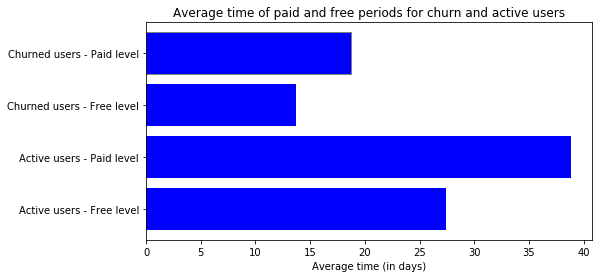

In [35]:
def plot_users_level_duration(df_churn0, df_churn1):
    """
    This function calculates the duration that free and paid users were using sparkify
        input:
        df_churn0: Dataframe of active users (df.churn==0)
        df_churn1: Dataframe of churn users (df.churn==1)
    Output: none (figure)
    """

    ## duration (in day) of being on "paid" level for each user is churn-1
    df_churn1_paid_time = df_churn1.filter(df_churn1.level=='paid').groupby("userId")\
                            .agg( (((Fmax("ts"))- (Fmin("ts")))/86400000.).alias("ts_paid") )

    ## duration (in day) of being on "free" level for each user is churn-1
    df_churn1_free_time = df_churn1.filter(df_churn1.level=='free').groupby("userId")\
                            .agg( (((Fmax("ts"))- (Fmin("ts")))/86400000.).alias("ts_free") )


    ## duration (in day) of being on "paid" level for each user is churn 0
    df_churn0_paid_time = df_churn0.filter(df_churn0.level=='paid').groupby("userId")\
                            .agg( (((Fmax("ts"))- (Fmin("ts")))/86400000.).alias("ts_paid") )

    ## duration (in day) of being on "free" level for each user is churn 0
    df_churn0_free_time = df_churn0.filter(df_churn0.level=='free').groupby("userId")\
                            .agg( (((Fmax("ts"))- (Fmin("ts")))/86400000.).alias("ts_free") )


    churn1_level_time = df_churn1_paid_time.join(df_churn1_free_time, df_churn1_paid_time.userId == df_churn1_free_time.userId, "inner")\
            .select(df_churn1_free_time.userId, df_churn1_paid_time.ts_paid, df_churn1_free_time.ts_free)


    churn0_level_time = df_churn0_paid_time.join(df_churn0_free_time, df_churn0_paid_time.userId == df_churn0_free_time.userId, "inner")\
            .select(df_churn0_free_time.userId, df_churn0_paid_time.ts_paid, df_churn0_free_time.ts_free)

    churn1_paid_avg = df_churn1_paid_time.select(Favg("ts_paid")).toPandas().iloc[0,0].tolist()
    churn1_free_avg = df_churn1_free_time.select(Favg("ts_free")).toPandas().iloc[0,0].tolist()
    churn0_paid_avg = df_churn0_paid_time.select(Favg("ts_paid")).toPandas().iloc[0,0].tolist()
    churn0_free_avg = df_churn0_free_time.select(Favg("ts_free")).toPandas().iloc[0,0].tolist()
    
    churn_level_days = [churn1_paid_avg, churn1_free_avg, churn0_paid_avg, churn0_free_avg]
    
    churn_level = ["Churned users - Paid level",
             "Churned users - Free level",
             "Active users - Paid level",
             "Active users - Free level"]

    fig = plt.figure(figsize =(8, 4))
    plt.barh(churn_level, churn_level_days, color ='blue', edgecolor ='grey')
    plt.title("Average time of paid and free periods for churn and active users")
    plt.xlabel('Average time (in days)')
    plt.show()
    

plot_users_level_duration(df_churn0, df_churn1)

From the above figure, it is obvious that churn users used sparkify for shorter duration of time, regardless of being paid or free. In addition, for both of the churn and active users, the paid users have used the app for longer time, which is reasonable.

#### 2.2.6. Variations of "location" for active and churn users (5 most popular cities and states):

In [84]:
def get_coordinates(location):
    """
    This function finds the latitude and longitude of a location (here, city)
    Inputs:
        location: name of location (string)
    
    Outputs: latitude , longitude: latitude and longitude coordinates of the location  
    """
    geolocatorz = Nominatim(user_agent='myapplication')
    location = geolocatorz.geocode(location)
    return location.latitude , location.longitude



def plot_geographical_distribution(df_churn0, df_churn1):
    """
    This function plots the geographical distribution of users based on their city
    Inputs: none
    Output: none (figure)
        
    """
    
    ## create the appropriate dataframe
    df0= df_churn0.select("userId", 'city', "churned_user").dropDuplicates(["userId"]).toPandas()
    df1= df_churn1.select("userId", 'city', "churned_user").dropDuplicates(["userId"]).toPandas()
    
    ## add blue and red colors for active and churned user, respectively
    df0["marker_color"] = df0["churned_user"].apply(lambda x: 'red' if x==True else 'blue')
    df1["marker_color"] = df1["churned_user"].apply(lambda x: 'red' if x==True else 'blue')
    
    ## dataframe for cities
    df_city = pd.concat([df0, df1])
    df_city = df_city.drop(["churned_user"],  axis=1) 
    dfu = df_city.groupby('userId', as_index=False).first()
    dfc = dfu.groupby('city', as_index=False).first()

    ## create the latitude and longitude list for all cities
    latatidue_list = []
    longitude_list = []
    for city in dfc['city']:
        try:
            lat , long = get_coordinates(city)
        except:
            pass
        latatidue_list.append(lat)
        longitude_list.append(long)

    ### create the final dataframe for mapping
    d = {'userId':dfc['userId'].tolist() , 
         'latitude': latatidue_list, 
         'longitude': longitude_list, 
         'marker_color':dfc['marker_color']}

    df_cor = pd.DataFrame(data=d)

    ## start the geographical map
    site_map = folium.Map()
    initial_coordinate = df_cor.iloc[0, 1:3].tolist() ## initial coordinate of the map
    site_map = folium.Map(location=initial_coordinate, zoom_start=10)
    # Initialize the map
    site_map = folium.Map(location=initial_coordinate, zoom_start=3)

    # For each user, add a Circle object based on the city coordinate (Lat, Long) values.
    for userId, lat, long, clr in zip(df_cor['userId'], df_cor['latitude'], df_cor['longitude'], df_cor['marker_color']):
        coordinate = [lat, long]
        # Create a blue/red circle with a popup label showing its userId
        circle = folium.Circle(coordinate, radius=1000, color=clr, fill=True).add_child(folium.Popup(userId))
        # Create a blue circle  with a icon showing its name
        marker = folium.map.Marker(
                        coordinate,
                        # Create an icon as a text label
                        icon=DivIcon(icon_size=(20,20), icon_anchor=(0,0), html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % userId,)
                        )
        site_map.add_child(circle)
        #  site_map.add_child(marker)

    ## adding marker cluster
    marker_cluster = MarkerCluster()
    # Add marker_cluster to current site_map
    site_map.add_child(marker_cluster);

    for index, record in df_cor.iterrows():
        iconValue=folium.Icon(color='white', icon_color = record[3])
        marker = folium.Marker(
                        location=[record[1], record[2]],
                        icon = iconValue,
                        popup=record[0],)
        marker_cluster.add_child(marker)

    display(site_map) 

    
plot_geographical_distribution(df_churn0, df_churn1)
    
    

Please zoom and click on the above map to see more details. The blue and green circles shows the city of the active and churned users, respectively. By clicking on te circles a number will show up that presents the userId.

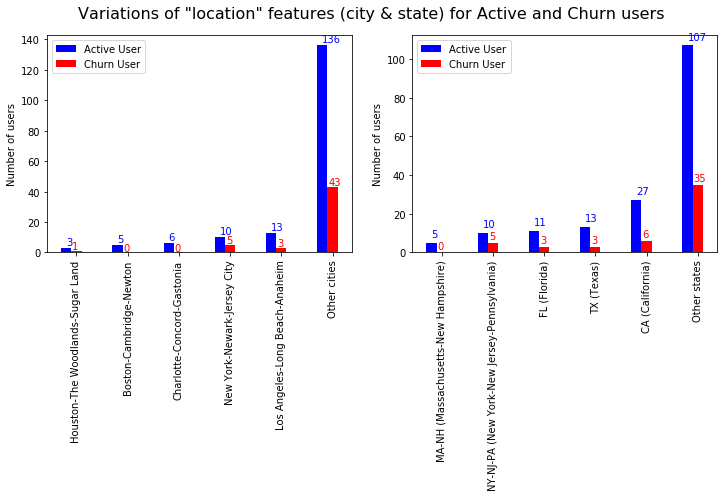

17.3% Churn users are in the 5 most popular cities, while 21.4% of Active user are in the 5 most popular cities
32.7% Churn users are in the 5 most popular staes, while 38.2% of Active user are in the 5 most popular staess


In [85]:
def plot_location(df_churn0, df_churn1):
    """
    This function plots the variation of "city_5" and "state_5" columns for the churn and active users
    input:
        df_churn0: Dataframe of active users (df.churn==0)
        df_churn1: Dataframe of churn users (df.churn==1)
        
    Output: none (figures)
    """
    
    # Number of churn and active users
    n0 = df_churn0.select("userId").dropDuplicates().count()*1.0
    n1 = df_churn1.select("userId").dropDuplicates().count()*1.0
    
    # city counts for active and churn users
    ch0 = df_churn0.select("userId", 'city_5').dropDuplicates(['userId']).groupBy("city_5").count().toPandas().sort_values(by=['count'])
    ch1 = df_churn1.select("userId", 'city_5').dropDuplicates(['userId']).groupBy("city_5").count().toPandas().sort_values(by=['count'])
    ch =ch0.merge(ch1, on='city_5', how='outer')
    # convert to list for plotting
    ch0_count = ch['count_x'].apply(lambda x: 0 if pd.isna(x) else int(x)).tolist()
    ch1_count = ch['count_y'].apply(lambda x: 0 if pd.isna(x) else int(x)).tolist()
    
    # state counts for active and churn users
    ch0_state = df_churn0.select("userId", 'state_5').dropDuplicates(['userId']).groupBy("state_5").count().toPandas().sort_values(by=['count'])
    ch1_state = df_churn1.select("userId", 'state_5').dropDuplicates(['userId']).groupBy("state_5").count().toPandas().sort_values(by=['count'])
    ch_state =ch0_state.merge(ch1_state, on='state_5', how='outer')
    # convert to list for plotting
    ch0_count_state = ch_state['count_x'].apply(lambda x: 0 if pd.isna(x) else int(x)).tolist()
    ch1_count_state = ch_state['count_y'].apply(lambda x: 0 if pd.isna(x) else int(x)).tolist()
    

    
    ## plot
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))
    fig.suptitle('Variations of "location" features (city & state) for Active and Churn users', fontsize=16)

    barWidth = 0.2
    # Set position of bar on X axis
    br1 = np.arange(len(ch0))
    br2 = [x + barWidth for x in br1]

    # subplot 1
    axs[0].bar(br1,  ch0_count, color ='b', width = barWidth, label ='Active User')
    axs[0].bar(br2,  ch1_count, color ='r', width = barWidth, label ='Churn User')
    axs[0].set_ylabel('Number of users', fontsize = 10)
    axs[0].set_xticks([r + barWidth for r in range(len(ch0))])
    axs[0].set_xticklabels(['Houston-The Woodlands-Sugar Land',
                'Boston-Cambridge-Newton', 
                'Charlotte-Concord-Gastonia', 
                'New York-Newark-Jersey City', 
                'Los Angeles-Long Beach-Anaheim', 
                'Other cities'],
                 rotation=90)
    axs[0].legend(loc='best')
    # Add text values
    for i, v in enumerate(ch0_count):
        axs[0].text(i , v+2 , str(v), color = 'blue')
    for i, v in enumerate(ch1_count):
        axs[0].text(i+0.12 , v+1 , str(v), color = 'red')
            
            
    # subplot 2
    axs[1].bar(br1,  ch0_count_state, color ='b', width = barWidth, label ='Active User')
    axs[1].bar(br2,  ch1_count_state, color ='r', width = barWidth, label ='Churn User')
    axs[1].set_ylabel('Number of users', fontsize = 10)
    axs[1].set_xticks([r + barWidth for r in range(len(ch0))])
    axs[1].set_xticklabels(['MA-NH (Massachusetts-New Hampshire)',
                            'NY-NJ-PA (New York-New Jersey-Pennsylvania)',
                            'FL (Florida)',
                            'TX (Texas)',
                            'CA (California)',
                            'Other states'],
                             rotation=90)
    axs[1].legend(loc='best')
    # Add text values
    for i, v in enumerate(ch0_count_state):
        axs[1].text(i , v+3 , str(v), color = 'blue')
    for i, v in enumerate(ch1_count_state):
        axs[1].text(i+0.12 , v+2 , str(v), color = 'red')
    
    plt.show()
    
    
    
    ## See how many churn and active users are in the 5 most popular cities
    churn0_cities5 = df_churn0.filter(col('city_5').isNotNull()).select('userId').dropDuplicates().count()
    churn1_cities5 = df_churn1.filter(col('city_5').isNotNull()).select('userId').dropDuplicates().count()
    print('%.1f%% Churn users are in the 5 most popular cities, while %.1f%% of Active user are in the 5 most popular cities'\
          % (churn1_cities5/n1*100., churn0_cities5/n0*100.))
    
    
    ## See how many churn and active users are in the 5 most popular states
    churn0_staes5 = df_churn0.filter(col('state_5').isNotNull()).select('userId').dropDuplicates().count()
    churn1_staes5 = df_churn1.filter(col('state_5').isNotNull()).select('userId').dropDuplicates().count()
    print('%.1f%% Churn users are in the 5 most popular staes, while %.1f%% of Active user are in the 5 most popular staess'\
          % (churn1_staes5/n1*100., churn0_staes5/n0*100.))


plot_location(df_churn0, df_churn1)


It can be seen that active users are relatively more present in the 5 most popular cities compared to the churn users. Thus, the 5 most popular cities will be considered as a feature in modeling.
Same thing also holds for the 5 most popular states.

###### 2.2.7. Variations of "page"  feature for active and churn users:

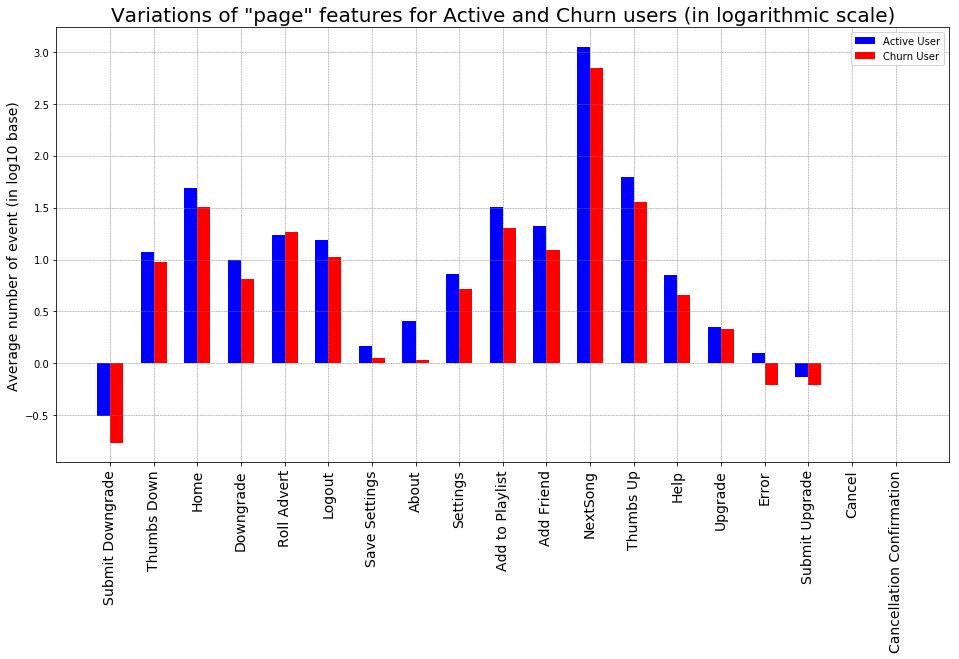

In [86]:
from math import log

def plot_page(df_churn0, df_churn1):
    """
    This function plots the sum of "length" column values for the churn and active users
    input:
        df_churn0: Dataframe of active users (df.churn==0)
        df_churn1: Dataframe of churn users (df.churn==1)
        
    Output: none (2 sub-figures)
    """
    
    # Number of churn and active users
    n0 = df_churn0.select("userId").dropDuplicates().count()*1.0
    n1 = df_churn1.select("userId").dropDuplicates().count()*1.0
    
    ch0 = df_churn0.select("userId", 'page').groupBy("page").count().toPandas()
    ch1 = df_churn1.select("userId", 'page').groupBy("page").count().toPandas()
    ch = ch0.merge(ch1, on='page', how='outer')
    
    # convert to list for plotting
    ch0_count = ch['count_x'].apply(lambda x: 0 if pd.isna(x) else log(x/n0, 10)).tolist()
    ch1_count = ch['count_y'].apply(lambda x: 0 if pd.isna(x) else log(x/n1, 10)).tolist()
    
    
    # plot
    barWidth = 0.3
    # Set position of bar on X axis
    br1 = np.arange(len(ch1_count))
    br2 = [x + barWidth for x in br1]

    ch_columns = ch['page'].tolist()
    fig = plt.figure(figsize=(16, 8))
    plt.title('Variations of "page" features for Active and Churn users (in logarithmic scale)', fontsize=20)
    plt.bar(br1, ch0_count, color ='b', width = barWidth, label ='Active User')
    plt.bar(br2, ch1_count, color ='r', width = barWidth, label ='Churn User')
    plt.ylabel('Average number of event (in log10 base)', fontsize = 14)
    plt.xticks([r+barWidth/2 for r in range(len(ch1))], ch_columns, rotation=90, fontsize=14)
    plt.legend(loc='best')
    plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    
    plt.show()

plot_page(df_churn0, df_churn1)


For most of the page events, the Active users present higher values rather than Churn user, except for the "Roll Advert" event. Please note that the figure is plotted in logarithmic scale as the "NextSong" has very large value compared to other events. In addition, the "cancel" and "Cancellation Confirmation" is zero for Active users, while they are 1 (in average) for Churn user, and accordingly they are not presented in this logarithmic scale. All of the events will be considered for modeling except the "cancel" and "Cancellation Confirmation" features as they represent the churn.

Let's investigate the "Roll Advert" event in more details by considering the weekday of Roll Advert events:

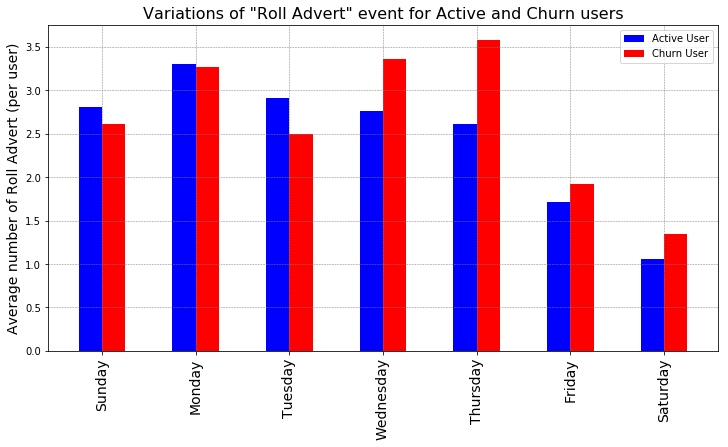

In [87]:
def plot_RollAdvert(df_churn0, df_churn1):
    """
    This function plots variations of RollAdvert for the churn and active users
    for different weekdays
    input:
        df_churn0: Dataframe of active users (df.churn==0)
        df_churn1: Dataframe of churn users (df.churn==1)
        
    Output: none (figures)
    """
    # Number of churn and active users
    n0 = df_churn0.select("userId").dropDuplicates().count()*1.0
    n1 = df_churn1.select("userId").dropDuplicates().count()*1.0

    ## 2) find the number of RollAdvert in each weekday for churn and active users
    ch0 = df_churn0.filter(df_churn0.page == "Roll Advert")\
                            .groupby(df_churn0.weekday)\
                            .agg((count('weekday')/n0).alias('count_avg'))\
                            .orderBy(df_churn0.weekday.cast("float"))\
                            .toPandas()

    ch1 = df_churn1.filter(df_churn1.page == "Roll Advert")\
                            .groupby(df_churn1.weekday)\
                            .agg((count('weekday')/n1).alias('count_avg'))\
                            .orderBy(df_churn1.weekday.cast("float"))\
                            .toPandas()

    ch = ch0.merge(ch1, on='weekday', how='outer')

    # convert to list for plotting
    ch0_count = ch['count_avg_x'].apply(lambda x: 0 if pd.isna(x) else float(x)).tolist()
    ch1_count = ch['count_avg_y'].apply(lambda x: 0 if pd.isna(x) else float(x)).tolist()


    # plot
    barWidth = 0.25
    # Set position of bar on X axis
    br1 = np.arange(len(ch1_count))
    br2 = [x + barWidth for x in br1]

    ch_columns = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    fig = plt.figure(figsize=(12, 6))
    plt.title('Variations of "Roll Advert" event for Active and Churn users', fontsize=16)
    plt.bar(br1, ch0_count, color ='b', width = barWidth, label ='Active User')
    plt.bar(br2, ch1_count, color ='r', width = barWidth, label ='Churn User')
    plt.ylabel('Average number of Roll Advert (per user)', fontsize = 14)
    plt.xticks([r+barWidth/2 for r in range(len(ch1))], ch_columns, rotation=90, fontsize=14)
    plt.legend(loc='best')
    plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    
    plt.show()
    

plot_RollAdvert(df_churn0, df_churn1)

Obviously, the churn users visit Roll Advert page more than Active users from Wednesday to Saturday. Therefore, this will be considered in the modelling.

Next, the "NextSong" event will be investigated in more details in terms of hourly, daily, monthly, and yearly use.

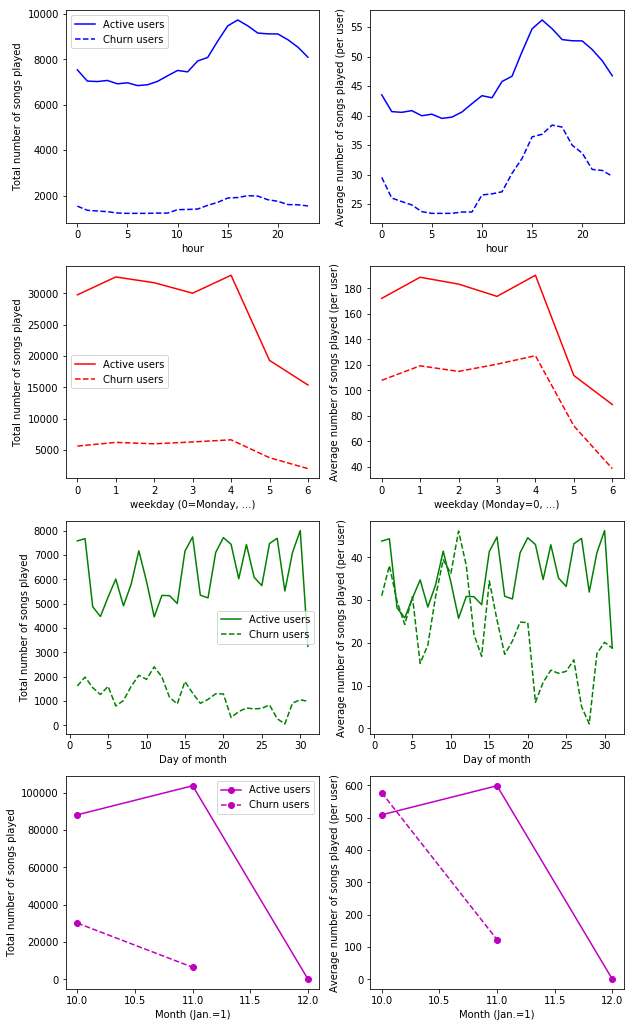

In [88]:
def plot_users_played_songs(df_churn0, df_churn1):
    """
    This function plots the NextSong event for different hours, 
    weekdays, days of month, and month.
    
    input:
        df_churn0: Dataframe of active users (df.churn==0)
        df_churn1: Dataframe of churn users (df.churn==1)
        
    Output: none (8 sub-figures)
    """
    

    ## 1) find the number of songs being played in each hour for churned and active users
    num_users_churn0 = df_churn0.select("userId").dropDuplicates().count()*1.0
    num_users_churn1 = df_churn1.select("userId").dropDuplicates().count()*1.0

    ## 1.A) total number and average number of songs played for active users (per hour)
    churn0_songs_hour = df_churn0.filter(df_churn0.page == "NextSong")\
                        .groupby(df_churn0.hour)\
                        .agg((count('hour')).alias('count'), (count('hour')/num_users_churn0).alias('average'))\
                        .orderBy(df_churn0.hour.cast("float"))
    churn0_songs_hour_pd = churn0_songs_hour.toPandas() # convert to pandas dataframe
    churn0_songs_hour_pd.hour = pd.to_numeric(churn0_songs_hour_pd.hour)

    ## 1.B) total number and average number of songs played for churn users (per hour)
    churn1_songs_hour = df_churn1.filter(df_churn1.page == "NextSong")\
                        .groupby(df_churn1.hour)\
                        .agg((count('hour')).alias('count'), (count('hour')/num_users_churn1).alias('average'))\
                        .orderBy(df_churn1.hour.cast("float"))
    churn1_songs_hour_pd = churn1_songs_hour.toPandas() # convert to pandas dataframe
    churn1_songs_hour_pd.hour = pd.to_numeric(churn1_songs_hour_pd.hour)
    
    
    ## 2) find the number of songs being played in each weekday for churned and active users
    ## 2.A) total number and average number of songs played for active users (per weekday) 
    churn0_songs_weekday = df_churn0.filter(df_churn0.page == "NextSong")\
                        .groupby(df_churn0.weekday)\
                        .agg((count('weekday')).alias('count'), (count('weekday')/num_users_churn0).alias('average'))\
                        .orderBy(df_churn0.weekday.cast("float"))
    churn0_songs_weekday_pd = churn0_songs_weekday.toPandas() # convert to pandas dataframe
    churn0_songs_weekday_pd.weekday = pd.to_numeric(churn0_songs_weekday_pd.weekday)

    ## 2.B) total number and average number of songs played for churn users (per weekday)
    churn1_songs_weekday = df_churn1.filter(df_churn1.page == "NextSong")\
                        .groupby(df_churn1.weekday)\
                        .agg((count('weekday')).alias('count'), (count('weekday')/num_users_churn1).alias('average'))\
                        .orderBy(df_churn1.weekday.cast("float"))
    churn1_songs_weekday_pd = churn1_songs_weekday.toPandas() # convert to pandas dataframe
    churn1_songs_weekday_pd.weekday = pd.to_numeric(churn1_songs_weekday_pd.weekday)
    
    

    ## 3) find the number of songs being played in each day of month for churned and active users
    ## 3.A) total number and average number of songs played for active users (per day of month) 
    churn0_songs_day = df_churn0.filter(df_churn0.page == "NextSong")\
                        .groupby(df_churn0.day)\
                        .agg((count('day')).alias('count'), (count('day')/num_users_churn0).alias('average'))\
                        .orderBy(df_churn0.day.cast("float"))
    churn0_songs_day_pd = churn0_songs_day.toPandas() # convert to pandas dataframe
    churn0_songs_day_pd.day = pd.to_numeric(churn0_songs_day_pd.day)
    
    ## 3.B) total number and average number of songs played for churn users (per day of month) 
    churn1_songs_day = df_churn1.filter(df_churn1.page == "NextSong")\
                        .groupby(df_churn1.day)\
                        .agg((count('day')).alias('count'), (count('day')/num_users_churn1).alias('average'))\
                        .orderBy(df_churn1.day.cast("float"))
    churn1_songs_day_pd = churn1_songs_day.toPandas() # convert to pandas dataframe
    churn1_songs_day_pd.day = pd.to_numeric(churn1_songs_day_pd.day)
    
    
    
    
    
    ## 4) find the number of songs being played in each month for churned and active users
    ## 4.A) total number and average number of songs played for active users (per month) 
    churn0_songs_month = df_churn0.filter(df_churn0.page == "NextSong")\
                        .groupby(df_churn0.month)\
                        .agg((count('month')).alias('count'), (count('month')/num_users_churn0).alias('average'))\
                        .orderBy(df_churn0.month.cast("int"))
    churn0_songs_month_pd = churn0_songs_month.toPandas() # convert to pandas dataframe
    churn0_songs_month_pd.month = pd.to_numeric(churn0_songs_month_pd.month)
    
    ## 4.B) total number and average number of songs played for churn users (per month)
    churn1_songs_month = df_churn1.filter(df_churn1.page == "NextSong")\
                        .groupby(df_churn1.month)\
                        .agg((count('month')).alias('count'), (count('month')/num_users_churn1).alias('average'))\
                        .orderBy(df_churn1.month.cast("int"))
    churn1_songs_month_pd = churn1_songs_month.toPandas() # convert to pandas dataframe
    churn1_songs_month_pd.month = pd.to_numeric(churn1_songs_month_pd.month)
    
    
    
    ## plot the figures
    fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(10, 18))
    
    # subplot 1
    x0 = churn0_songs_hour_pd['hour']
    y0 = churn0_songs_hour_pd['count']
    x1 = churn1_songs_hour_pd['hour']
    y1 = churn1_songs_hour_pd['count']
    axs[0, 0].plot(x0, y0, '-', c='b', label='Active users')
    axs[0, 0].plot(x1, y1, '--', c='b', label='Churn users')
    axs[0, 0].set_xlabel('hour')
    axs[0, 0].set_ylabel('Total number of songs played')
    axs[0, 0].legend(loc='best')
    
    # subplot 2
    x0 = churn0_songs_hour_pd['hour']
    y0 = churn0_songs_hour_pd['average']
    x1 = churn1_songs_hour_pd['hour']
    y1 = churn1_songs_hour_pd['average']
    axs[0, 1].plot(x0, y0, '-', c='b', label='Active users')
    axs[0, 1].plot(x1, y1, '--', c='b', label='Churn users')
    axs[0, 1].set_xlabel('hour')
    axs[0, 1].set_ylabel('Average number of songs played (per user)')
    
    # subplot 3
    x0 = churn0_songs_weekday_pd['weekday']
    y0 = churn0_songs_weekday_pd['count']
    x1 = churn1_songs_weekday_pd['weekday']
    y1 = churn1_songs_weekday_pd['count']
    axs[1, 0].plot(x0, y0, '-', c='r', label='Active users')
    axs[1, 0].plot(x1, y1, '--', c='r', label='Churn users')
    axs[1, 0].set_xlabel('weekday (0=Monday, ...)')
    axs[1, 0].set_ylabel('Total number of songs played')
    axs[1, 0].legend(loc='best')
    
    # subplot 4
    x0 = churn0_songs_weekday_pd['weekday']
    y0 = churn0_songs_weekday_pd['average']
    x1 = churn1_songs_weekday_pd['weekday']
    y1 = churn1_songs_weekday_pd['average']
    axs[1, 1].plot(x0, y0, '-', c='r', label='Active users')
    axs[1, 1].plot(x1, y1, '--', c='r', label='Churn users')
    axs[1, 1].set_xlabel('weekday (Monday=0, ...)')
    axs[1, 1].set_ylabel('Average number of songs played (per user)')
    
    # subplot 5
    x0 = churn0_songs_day_pd['day']
    y0 = churn0_songs_day_pd['count']
    x1 = churn1_songs_day_pd['day']
    y1 = churn1_songs_day_pd['count']
    axs[2, 0].plot(x0, y0, '-', c='g', label='Active users')
    axs[2, 0].plot(x1, y1, '--', c='g', label='Churn users')
    axs[2, 0].set_xlabel('Day of month')
    axs[2, 0].set_ylabel('Total number of songs played')
    axs[2, 0].legend(loc='best')
    
    # subplot 6
    x0 = churn0_songs_day_pd['day']
    y0 = churn0_songs_day_pd['average']
    x1 = churn1_songs_day_pd['day']
    y1 = churn1_songs_day_pd['average']
    axs[2, 1].plot(x0, y0, '-', c='g', label='Active users')
    axs[2, 1].plot(x1, y1, '--', c='g', label='Churn users')
    axs[2, 1].set_xlabel('Day of month')
    axs[2, 1].set_ylabel('Average number of songs played (per user)')
    
    # subplot 7
    x0 = churn0_songs_month_pd['month']
    y0 = churn0_songs_month_pd['count']
    x1 = churn1_songs_month_pd['month']
    y1 = churn1_songs_month_pd['count']
    axs[3, 0].plot(x0, y0, 'o-', c='m', label='Active users')
    axs[3, 0].plot(x1, y1, 'o--', c='m', label='Churn users')
    axs[3, 0].set_xlabel('Month (Jan.=1)')
    axs[3, 0].set_ylabel('Total number of songs played')
    axs[3, 0].legend(loc='best')
    
    # subplot 8
    x0 = churn0_songs_month_pd['month']
    y0 = churn0_songs_month_pd['average']
    x1 = churn1_songs_month_pd['month']
    y1 = churn1_songs_month_pd['average']
    axs[3, 1].plot(x0, y0, 'o-', c='m', label='Active users')
    axs[3, 1].plot(x1, y1, 'o--', c='m', label='Churn users')
    axs[3, 1].set_xlabel('Month (Jan.=1)')
    axs[3, 1].set_ylabel('Average number of songs played (per user)')
    
    plt.show()
    
    
# Plots different activities of the churn and active users
plot_users_played_songs(df_churn0, df_churn1)


From the above figure, one can see that although the average number of songs played played by Churn users are smaller than Active users, in general, they show similar trends.

###### 2.2.8. Variations of "song_100"  feature for active and churn users:

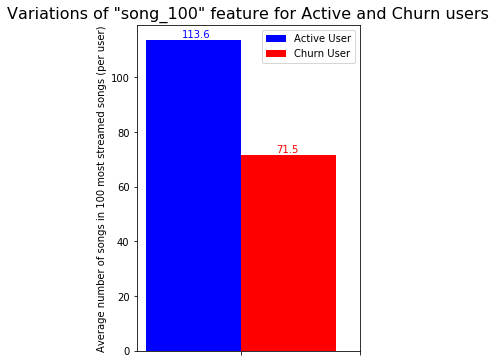

In [89]:
def plot_song100(df_churn0, df_churn1):
    """
    This function plots the sum of "song_100" column values for the churn and active users
    input:
        df_churn0: Dataframe of active users (df.churn==0)
        df_churn1: Dataframe of churn users (df.churn==1)
        
    Output: none (figure)
    """
    
    # Number of churn and active users
    n0 = df_churn0.select("userId").dropDuplicates().count()*1.0
    n1 = df_churn1.select("userId").dropDuplicates().count()*1.0
    
    ch0 = df_churn0.select("userId", 'song_100').groupBy("song_100").count().toPandas()
    ch1 = df_churn1.select("userId", 'song_100').groupBy("song_100").count().toPandas()

    # convert to list for plotting
    ch1_count = ch1['count'].tolist()
    ch0_count = ch0['count'].tolist()

    # Take average
    ch1_count = [ch1_count[1]/n1]
    ch0_count = [ch0_count[1]/n0]
    

    # plot
    barWidth = 0.8
    # Set position of bar on X axis
    br1 = np.arange(len(ch1_count))
    br2 = [x + barWidth for x in br1]

    fig = plt.figure(figsize=(4, 6))
    plt.title('Variations of "song_100" feature for Active and Churn users', fontsize=16)
    plt.bar(br1, ch0_count, color ='b', width = barWidth, label ='Active User')
    plt.bar(br2, ch1_count, color ='r', width = barWidth, label ='Churn User')
    plt.ylabel('Average number of songs in 100 most streamed songs (per user)', fontsize = 10)
    plt.xticks([r+barWidth/2 for r in range(len(ch1))], [''])
    plt.legend(loc='best')
    # Add text values
    for i, v in enumerate(ch0_count):
        plt.text(i-0.1 , v+1 , str(round(v, 1)), color = 'blue')
    for i, v in enumerate(ch1_count):
        plt.text(i+0.7 , v+1 , str(round(v, 1)), color = 'red')
    
    plt.show()


plot_song100(df_churn0, df_churn1)


Unsuprisingly, Active users have more songs in the 100 most streamed songs list compared to the Churn users. Therefore, the number of song_100 will be considered in modeling. Same behavior also holds for artis_5 feature, as shown in below figure.

###### 2.2.9. Variations of "artist_5"  feature for active and churn users:

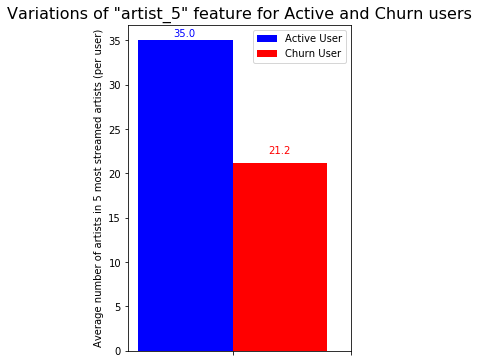

In [90]:
def plot_artist5(df_churn0, df_churn1):
    """
    This function plots the sum of "artist_5" column values for the churn and active users
    input:
        df_churn0: Dataframe of active users (df.churn==0)
        df_churn1: Dataframe of churn users (df.churn==1)
        
    Output: none (figure)
    """
    
    # Number of churn and active users
    n0 = df_churn0.select("userId").dropDuplicates().count()*1.0
    n1 = df_churn1.select("userId").dropDuplicates().count()*1.0
    
    ch0 = df_churn0.select("userId", 'artist_5').groupBy("artist_5").count().toPandas()
    ch1 = df_churn1.select("userId", 'artist_5').groupBy("artist_5").count().toPandas()

    ## convert to list for plotting
    ch1_count = ch1['count'].tolist()
    ch0_count = ch0['count'].tolist()

    # Take average
    ch1_count = [ch1_count[1]/n1]
    ch0_count = [ch0_count[1]/n0]
    

    # plot
    barWidth = 0.8
    # Set position of bar on X axis
    br1 = np.arange(len(ch1_count))
    br2 = [x + barWidth for x in br1]

    fig = plt.figure(figsize=(4, 6))
    plt.title('Variations of "artist_5" feature for Active and Churn users', fontsize=16)
    plt.bar(br1, ch0_count, color ='b', width = barWidth, label ='Active User')
    plt.bar(br2, ch1_count, color ='r', width = barWidth, label ='Churn User')
    plt.ylabel('Average number of artists in 5 most streamed artists (per user)', fontsize = 10)
    plt.xticks([r+barWidth/2 for r in range(len(ch1))], [''])
    plt.legend(loc='best')
    # Add text values
    for i, v in enumerate(ch0_count):
        plt.text(i-0.1 , v+0.4 , str(round(v, 1)), color = 'blue')
    for i, v in enumerate(ch1_count):
        plt.text(i+0.7 , v+1 , str(round(v, 1)), color = 'red')
    
    plt.show()

plot_artist5(df_churn0, df_churn1)

###### 2.2.10. Variations of "downgraded"  feature for active and churn users:

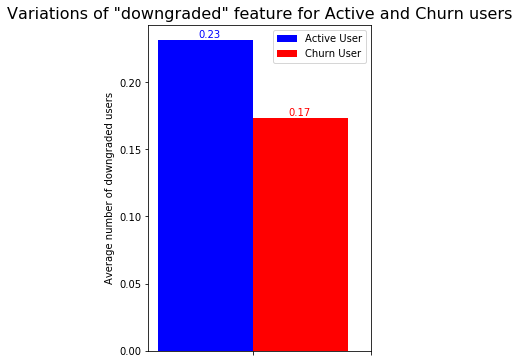

In [91]:
def plot_downgraded(df_churn0, df_churn1):
    """
    This function plots the sum of "downgraded" column values for the churn and active users
    input:
        df_churn0: Dataframe of active users (df.churn==0)
        df_churn1: Dataframe of churn users (df.churn==1)
        
    Output: none (figure)
    """
    
    # Number of churn and active users
    n0 = df_churn0.select("userId").dropDuplicates().count()*1.0
    n1 = df_churn1.select("userId").dropDuplicates().count()*1.0
    
    ch0 = df_churn0.select("userId", "downgraded").toPandas().groupby('userId').max().reset_index()
    ch0 = ch0[ch0['downgraded']==1].count()

    ch1 = df_churn1.select("userId", "downgraded").toPandas().groupby('userId').max().reset_index()
    ch1 = ch1[ch1['downgraded']==1].count()

    ## convert to list for plotting
    ch1_count = [ch1.downgraded/n1]
    ch0_count = [ch0.downgraded/n0]
    

    # plot
    barWidth = 0.8
    # Set position of bar on X axis
    br1 = np.arange(len(ch1_count))
    br2 = [x + barWidth for x in br1]

    fig = plt.figure(figsize=(4, 6))
    plt.title('Variations of "downgraded" feature for Active and Churn users', fontsize=16)
    plt.bar(br1, ch0_count, color ='b', width = barWidth, label ='Active User')
    plt.bar(br2, ch1_count, color ='r', width = barWidth, label ='Churn User')
    plt.ylabel('Average number of downgraded users', fontsize = 10)
    plt.xticks([r+barWidth/2 for r in range(len(ch1))], [''])
    plt.legend(loc='best')
    # Add text values
    for i, v in enumerate(ch0_count):
        plt.text(i-0.06 , v+0.002 , str(round(v, 2)), color = 'blue')
    for i, v in enumerate(ch1_count):
        plt.text(i+0.7 , v+0.002 , str(round(v, 2)), color = 'red')
    
    plt.show()

plot_downgraded(df_churn0, df_churn1)

Interestingly, the average number of downgraded users is higher for the Active users in comparison to Churn users. It seems that churn users tend to cancel the service without downgrading from paid to free first. The downgraded feature will be considered in modeling. 

###### 2.2.11. Variations of "user_Agent"  features for active and churn users:

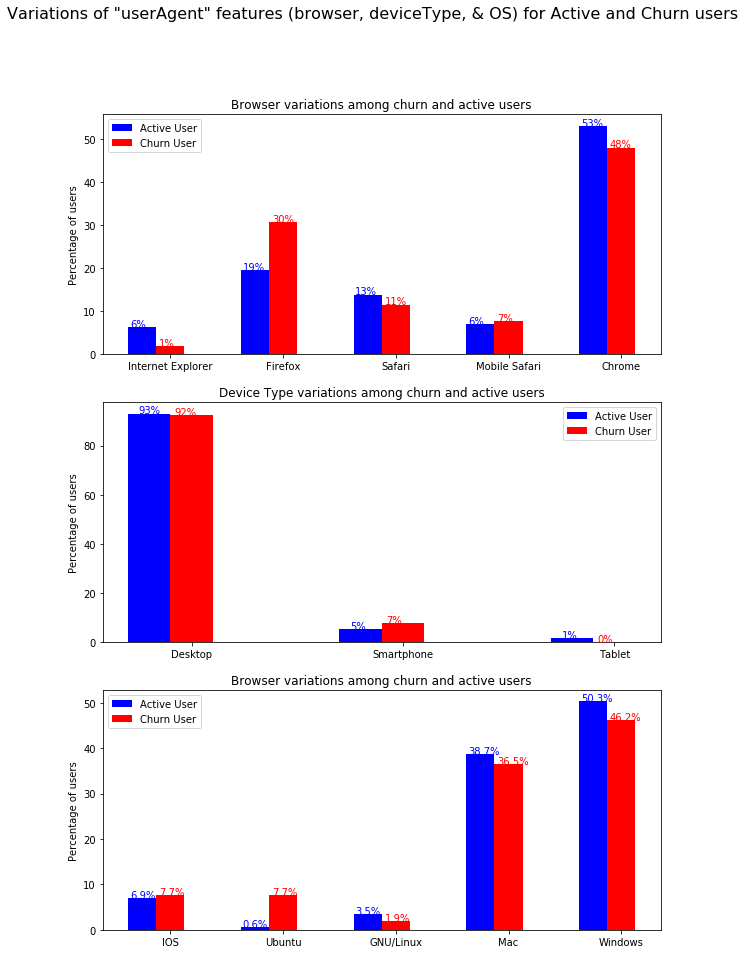

In [92]:
def plot_userAgent(df_churn0, df_churn1):
    """
    This function plots the variation of browser, operation system, and
    device type for the churn and active users
    input:
        df_churn0: Dataframe of active users (df.churn==0)
        df_churn1: Dataframe of churn users (df.churn==1)
        
    Output: none (figures)
    """

    # Number of churn and active users
    n0 = df_churn0.select("userId").dropDuplicates().count()*1.0
    n1 = df_churn1.select("userId").dropDuplicates().count()*1.0
    
    # browser counts for active and churn users
    ch0 = df_churn0.select("userId", 'userAgent_browser').dropDuplicates(['userId']).groupBy("userAgent_browser").count().toPandas()
    ch1 = df_churn1.select("userId", 'userAgent_browser').dropDuplicates(['userId']).groupBy("userAgent_browser").count().toPandas()
    ch =ch0.merge(ch1, on='userAgent_browser', how='outer')
    # convert to list for plotting
    ch0_count_browser = ch['count_x'].apply(lambda x: 0 if pd.isna(x) else x/n0*100.).tolist()
    ch1_count_browser = ch['count_y'].apply(lambda x: 0 if pd.isna(x) else x/n1*100).tolist()
    
    # DeviceType counts for active and churn users
    ch0 = df_churn0.select("userId", 'userAgent_deviceType').dropDuplicates(['userId']).groupBy("userAgent_deviceType").count().toPandas()
    ch1 = df_churn1.select("userId", 'userAgent_deviceType').dropDuplicates(['userId']).groupBy("userAgent_deviceType").count().toPandas()
    ch =ch0.merge(ch1, on='userAgent_deviceType', how='outer')
    # convert to list for plotting
    ch0_count_deviceType = ch['count_x'].apply(lambda x: 0 if pd.isna(x) else x/n0*100.).tolist()
    ch1_count_deviceType = ch['count_y'].apply(lambda x: 0 if pd.isna(x) else x/n1*100).tolist()

    # Operating System counts for active and churn users
    ch0 = df_churn0.select("userId", 'userAgent_OS').dropDuplicates(['userId']).groupBy("userAgent_OS").count().toPandas()
    ch1 = df_churn1.select("userId", 'userAgent_OS').dropDuplicates(['userId']).groupBy("userAgent_OS").count().toPandas()
    ch =ch0.merge(ch1, on='userAgent_OS', how='outer')
    # convert to list for plotting
    ch0_count_OS = ch['count_x'].apply(lambda x: 0 if pd.isna(x) else x/n0*100.).tolist()
    ch1_count_OS = ch['count_y'].apply(lambda x: 0 if pd.isna(x) else x/n1*100).tolist()

    ## plot
    fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(10, 15))
    fig.suptitle('Variations of "userAgent" features (browser, deviceType, & OS) for Active and Churn users', fontsize=16)
  
     ## Subplot 1 
    barWidth = 0.25
    # Set position of bar on X axis
    br1 = np.arange(len(ch0_count_browser))
    br2 = [x + barWidth for x in br1]

    axs[0].bar(br1, ch0_count_browser, color ='b', width = barWidth, label ='Active User')
    axs[0].bar(br2, ch1_count_browser, color ='r', width = barWidth, label ='Churn User')
    axs[0].set_ylabel('Percentage of users', fontsize = 10)
    axs[0].set_xticks([r + barWidth for r in range(len(ch0_count_browser))])
    axs[0].set_xticklabels(['Internet Explorer',
                           'Firefox',
                           'Safari',
                           'Mobile Safari',
                           'Chrome'],
                 rotation=0)
    axs[0].legend(loc='best')
    axs[0].set_title('Browser variations among churn and active users')
    # Add text values
    for i, v in enumerate(ch0_count_browser):
        axs[0].text(i-0.11 , v+0.01 , str(int(v))+'%', color = 'blue')
    for i, v in enumerate(ch1_count_browser):
        axs[0].text(i+0.15 , v+0.01 , str(int(v))+'%', color = 'red')
        
           
    ## Subplot 2  
    barWidth = 0.2
    # Set position of bar on X axis
    br1 = np.arange(len(ch0_count_deviceType))
    br2 = [x + barWidth for x in br1]
    axs[1].bar(br1, ch0_count_deviceType, color ='b', width = barWidth, label ='Active User')
    axs[1].bar(br2, ch1_count_deviceType, color ='r', width = barWidth, label ='Churn User')
    axs[1].set_ylabel('Percentage of users', fontsize = 10)
    axs[1].set_xticks([r + barWidth for r in range(len(ch0_count_deviceType))])
    axs[1].set_xticklabels(['Desktop',
                           'Smartphone',
                           'Tablet'],
                            rotation=0)
    axs[1].legend(loc='best')
    axs[1].set_title('Device Type variations among churn and active users')
    # Add text values
    for i, v in enumerate(ch0_count_deviceType):
        axs[1].text(i-0.05 , v+0.01 , str(int(v))+'%', color = 'blue')
    for i, v in enumerate(ch1_count_deviceType):
        axs[1].text(i+0.12 , v+0.01 , str(int(v))+'%', color = 'red')
        
        
    ## Subplot 3 
    barWidth = 0.25
    # Set position of bar on X axis
    br1 = np.arange(len(ch0_count_OS))
    br2 = [x + barWidth for x in br1]

    axs[2].bar(br1, ch0_count_OS, color ='b', width = barWidth, label ='Active User')
    axs[2].bar(br2, ch1_count_OS, color ='r', width = barWidth, label ='Churn User')
    axs[2].set_ylabel('Percentage of users', fontsize = 10)
    axs[2].set_xticks([r + barWidth for r in range(len(ch0_count_OS))])
    axs[2].set_xticklabels(['IOS',
                           'Ubuntu',
                           'GNU/Linux',
                           'Mac',
                           'Windows'],
                 rotation=0)
    axs[2].legend(loc='best')
    axs[2].set_title('Browser variations among churn and active users')
    # Add text values
    for i, v in enumerate(ch0_count_OS):
        axs[2].text(i-0.11 , v+0.01 , str(round(v, 1))+'%', color = 'blue')
    for i, v in enumerate(ch1_count_OS):
        axs[2].text(i+0.15 , v+0.01 , str(round(v, 1))+'%', color = 'red')
            
    plt.show()
    

plot_userAgent(df_churn0, df_churn1)
    

In [108]:
# garbage collection
df_churn0.unpersist()
df_churn1.unpersist()
del df_churn0, df_churn1

NameError: name 'df_churn0' is not defined

From the above figures, one can see that the Firfox users have greater tendency for cancelig their service relative to active users. For the device type, there is not any significant difference between two groups of users. For the operating system, users with Ubunto OS are more inclined to cancel their service compared to active users.

All of these three features will be considered for modeling, although the device type does not seem promising at this initial/basic analysis.

# 3. Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

From the insight obtained from previous step the features for modeling will be created. In the "create-features" function below, all the features are defined and self-explaining comments are provided to describe the feature.

In [94]:
def create_features(df):
    """
    This function creates the features for modeling based on the insighrs found 
    from exploratory data analysis (EDA)
    
    Inputs:
        df: cleaned pyspark dataframe of the events
        
    Outputs:
        dfp_final : final dataframe in Pandas format
        dfs: final dataframe in PySpark format
    """
    
    ## Construct the user-membership_time dataset
    ## membership_time is the difference in time from the last recorded activity 
    ## to the first activity and is calculated based on day (86400 seconds)
    dfp = df.select("userId", "ts").toPandas()
    dfp_membership_time = dfp.groupby('userId', as_index=False)['ts']\
                          .agg(['min', 'max']).diff(axis=1)\
                          .rename(columns= {'max':'membership_time'})\
                           ['membership_time'].apply(lambda x: x/86400000)\
                          .reset_index()
    
    ## Construct the user-gender dataset
    dfp = df.select("userId", "gender").toPandas()
    dfp_gender = pd.concat([dfp, pd.get_dummies(dfp['gender'], prefix_sep='_', prefix='gender', drop_first=True)], axis=1)\
                        .groupby(['userId', 'gender_M']).max()\
                        .reset_index()\
                        .drop("gender", axis=1)
    
    
    ## Construct the user-itemInSession dataset
    ## The itemInSession is divided by the membership_time (day)
    dfp_itemInSession = df.select("userId", "itemInSession").toPandas()\
                        .groupby(["userId"], as_index=False).sum();
    dfp_itemInSession["itemInSession_perDay"] = dfp_itemInSession["itemInSession"]/dfp_membership_time['membership_time'];
    dfp_itemInSession.drop("itemInSession", axis=1, inplace=True);
    
    
    ## Construct the user-length dataset
    ## Length is divided by the membership_time (day)
    dfp_length = df.select("userId", "length").toPandas()\
                    .groupby(["userId"]).sum().reset_index()

    dfp_length["length_perDay"] = dfp_length["length"]/dfp_membership_time['membership_time'];
    dfp_length.drop("length", axis=1, inplace=True);
    
    
    ## Construct the user-level dataset
    ## initialy_free denotes if the user was using the free service at the beginning
    dfp = df.select("userId", "level", "ts").toPandas()\
                .sort_values(by=['ts'])\
                .groupby('userId', as_index=False).min()
    dfp['initially_free'] = dfp['level'].apply(lambda x: 1 if x=='free' else 0)
    dfp_level = dfp.drop(['level', 'ts'], axis=1)


    ## Construct the user-paid_time dataset
    ## paid_time features shows the amount of time that the user was paying (in days)
    dfp = df.select("userId", "ts", "level").toPandas()
    dfp = dfp[dfp.level=='paid']\
            .groupby('userId', as_index=False)['ts']\
            .agg(['min', 'max'])\
            .diff(axis=1)\
            .rename(columns= {'max':'paid_time'})\
            ['paid_time'].apply(lambda x: x/86400000)\
            .reset_index()

    dfp = dfp_membership_time.merge(dfp, on='userId', how='outer')
    dfp['paid_time_ratio'] = dfp.paid_time.div(dfp.membership_time, fill_value=0.)
    dfp_paid_time_ratio = dfp.drop(['membership_time', 'paid_time'], axis=1)
    
    
    ## Construct the user-city5 dataset
    ## city_5 contains the five most populated cities in terms of the count of users
    ## and it will be unstacked as dummy variables
    dfp = df.select("userId", "city_5").toPandas()
    dfp_city = pd.concat([dfp, pd.get_dummies(dfp['city_5'], prefix_sep='_', prefix='city', drop_first=False)], axis=1)\
                            .groupby(['userId']).max()\
                            .reset_index()\
                            .drop("city_5", axis=1)

    ## Construct the user-state5 dataset
    ## state_5 contains the five most populated state in terms of the count of users
    ## and it will be unstacked as dummy variables
    dfp = df.select("userId", "state_5").toPandas()
    dfp_state = pd.concat([dfp, pd.get_dummies(dfp['state_5'], prefix_sep='_', prefix='state', drop_first=False)], axis=1)\
                            .groupby(['userId']).max()\
                            .reset_index()\
                            .drop("state_5", axis=1)
    
    ## Construct the user-page dataset (divided by membership-time)
    dfp = df.select("userId", "page").toPandas()
    dfp_page = dfp.groupby(['userId', 'page'])['page'].count().unstack()
    dfp_page.replace(np.nan, 0, inplace=True) # replace NaN with 0
    dfp_page['userId'] = dfp_page.index # set userId as index
    col_list = dfp_page.columns[0:-1] # do not include the last item
    dfp = dfp_membership_time.merge(dfp_page, on='userId', how='outer') # add the membership_time
    dfp.loc[:, col_list] = dfp[col_list].div(dfp['membership_time'], axis=0)  # divide by membership_time 
    dfp_page = dfp.drop(["membership_time"], axis=1)  # remove the membership_time


    ## Construct the user-RolldAdvert dataset
    ## RolldAdvert is the count of rolladvert in each day of week, divided by membership-time
    dfp = df.select('userId', 'page', 'weekday').toPandas()

    dfp_roll = dfp[dfp.page=='Roll Advert']\
            .groupby(['userId','weekday'])['weekday'].count().unstack()
    dfp_roll.replace(np.nan, 0, inplace=True)
    dfp_roll['userId'] = dfp_roll.index
    dfp = dfp_membership_time.merge(dfp_roll, on='userId', how='outer')
    dfp[['RollAdvert_Mon', 'RollAdvert_Tue', 'RollAdvert_Wed', 'RollAdvert_Thu', 
         'RollAdvert_Fri', 'RollAdvert_Sat', 'RollAdvert_Sun']] = \
          dfp[[0,1,2,3,4,5,6]].div(dfp['membership_time'], axis=0)
    dfp_roll = dfp.drop([0,1,2,3,4,5,6, "membership_time"], axis=1)
    dfp_roll.replace(np.nan, 0, inplace=True)
    
    ## Construct the user-song100 dataset
    ## song100 dataset is the number (divided by membership-time) of songs 
    ## played by the user that are in the list of 100 most streamed songs
    dfp = df.select("userId", "song_100").toPandas()
    dfp.replace(np.nan, 0, inplace=True)
    dfp = dfp.astype({'song_100':'float'})
    dfp_song100 = dfp.groupby(["userId"]).sum().reset_index()
    dfp_song100["song_100"] = dfp_song100["song_100"]/dfp_membership_time['membership_time'];
    
    ## Construct the user-artist5 dataset
    ## artist5 dataset is the number (divided by membership-time) of artist 
    ## played by the user that are in the list of 5 most streamed artists
    dfp = df.select("userId", "artist_5").toPandas()
    dfp.replace(np.nan, 0, inplace=True)
    dfp = dfp.astype({'artist_5':'float'})
    dfp_artist5 = dfp.groupby(["userId"]).sum().reset_index()
    dfp_artist5["artist_5"] = dfp_artist5["artist_5"]/dfp_membership_time['membership_time'];
    
    ## Construct the user-downgraded dataset 
    ## downgraded dataset shows if the user has downgraded the service
    dfp_downgraded = df.select("userId", "downgraded").toPandas().groupby('userId').max().reset_index()

    ## Construct the user-browser dataset
    ## userAgent_browser dataset shows the browser used by the user
    dfp = df.select("userId", "userAgent_browser").toPandas()
    dfp_browser = pd.concat([dfp, pd.get_dummies(dfp['userAgent_browser'], prefix_sep='_', prefix='browser', drop_first=True)], axis=1)\
                             .drop_duplicates(subset=['userId']).drop("userAgent_browser", axis=1)
    
    ## Construct the user-deviceType dataset
    ## userAgent_deviceType shows the type of the device used by the user
    dfp = df.select("userId", "userAgent_deviceType").toPandas()
    dfp_deviceType = pd.concat([dfp, pd.get_dummies(dfp['userAgent_deviceType'], prefix_sep='_', prefix='deviceType', drop_first=True)], axis=1)\
                             .drop_duplicates(subset=['userId']).drop("userAgent_deviceType", axis=1)

    
    ## Construct the user-operating system dataset
    # userAgent_OS shows the operating system used by the user
    dfp = df.select("userId", "userAgent_OS").toPandas()
    dfp_OS = pd.concat([dfp, pd.get_dummies(dfp['userAgent_OS'], prefix_sep='_', prefix='OS', drop_first=True)], axis=1)\
                             .drop_duplicates(subset=['userId']).drop("userAgent_OS", axis=1)


    ## Construct the user-churn dataset
    # churn shows if the user has submitted "cancelation confirmation"
    dfp = df.select("userId", "churn").toPandas()
    dfp_churn = dfp.groupby(['userId'], as_index=False)['churn'].max()

    
    # Construct the final features-dataframe
    dataframes = [dfp_membership_time, 
              dfp_gender, 
              dfp_itemInSession,
              dfp_length, 
              dfp_level, 
              dfp_paid_time_ratio, 
              dfp_city, 
              dfp_state, 
              dfp_page, 
              dfp_roll, 
              dfp_song100,
              dfp_artist5, 
              dfp_downgraded, 
              dfp_browser, 
              dfp_deviceType, 
              dfp_OS,
              dfp_churn]


    dfp = reduce(lambda  left,right: pd.merge(left,right,on=['userId'],
                                             how='outer'), dataframes)
    dfp.rename(columns = {'churn':'label'}, inplace = True) # rename to label
    dfp_final = dfp.drop(['userId'], axis=1) # userId is not needed
    ## Cancellation Confirmation and cancel should be removed as they indicate churn
    dfp_final = dfp_final.drop(['Cancellation Confirmation'], axis=1)
    dfp_final = dfp_final.drop(['Cancel'], axis=1)

 
    ## Convert the dataframe to pyspark dataframe
    dfs = spark.createDataFrame(dfp_final)

    
    return dfp_final, dfs



In [95]:
def get_feature_names(dfp_final):
    
    """
    This function creates lists of binary, non-binary, and all features, which
    will be used later in scaling
    
    Inputs: dfp_final: final dataframe in Pandas format
    
    Outputs:
        binary_features: list of the names of the binary features (list)
        non_binary_features: list of the names of the non_binary features (list)
        features_list: list of names of all features (list)
    """
    
     ## get the names of all features (columns)
    features_list = dfp_final.columns.tolist()
    features_list.remove('label')

    ## get the column names for binary and non-binary columns 
    binary_features = ['gender_M',
               'initially_free',
                'city_Boston-Cambridge-Newton',
                'city_Charlotte-Concord-Gastonia',
                'city_Houston-The Woodlands-Sugar Land',
                'city_Los Angeles-Long Beach-Anaheim',
                'city_New York-Newark-Jersey City',
                'state_ CA',
                'state_ FL',
                'state_ MA-NH',
                'state_ NY-NJ-PA',
                'state_ TX',
                'downgraded',
                'browser_Firefox',
                'browser_Internet Explorer',
                'browser_Mobile Safari',
                'browser_Safari',
                'deviceType_smartphone',
                'deviceType_tablet',
                'OS_Mac',
                'OS_Ubuntu',
                'OS_Windows',
                'OS_iOS']
    
    # create the non-binary (numeric) features
    non_binary_features = []
    for col in features_list:
            if col not in binary_features:
                non_binary_features.append(col)

    print('Number of binary features is :', len(binary_features))
    print('Number of non-binary features is :', len(non_binary_features))
    
    return  binary_features, non_binary_features, features_list



In [96]:
def features_engineering_main(df):
    """
    This function creates the final dataframe and also lists of 
    features (binary, non-binary, all-tohether)
    
    Inputs: 
        df: Cleaned dataframe in PySpark format
        
    Outputs: 
        dfp_final : final dataframe in Pandas format
        dfs: final dataframe in PySpark format
        binary_features: list of the names of the binary features (list)
        non_binary_features: list of the names of the non_binary features (list)
        features_list: list of names of all features (list)
    """
    
    # create the final dataframe in Pandas and PySpark format
    dfp_final, dfs = create_features(df)
    
    # Get the lists of the features names (binary, non-binary, all-tohether)
    binary_features, non_binary_features, features_list = get_feature_names(dfp_final)
    
    
    return dfp_final, dfs, binary_features, non_binary_features, features_list
    
    
dfp_final, dfs, binary_features, non_binary_features, features_list = features_engineering_main(df)  

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:75: FutureWarning: 'userId' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:87: FutureWarning: 'userId' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


Number of binary features is : 23
Number of non-binary features is : 30


In [97]:
## Show the final data frame
pd.set_option('display.max_columns', None)
print("The numeber of rows of the final dataframe is %d and the columns are %d" % (dfp_final.shape[0],dfp_final.shape[1]))
dfp_final.head()

The numeber of rows of the final dataframe is 225 and the columns are 54


,membership_time,gender_M,itemInSession_perDay,length_perDay,initially_free,paid_time_ratio,city_Boston-Cambridge-Newton,city_Charlotte-Concord-Gastonia,city_Houston-The Woodlands-Sugar Land,city_Los Angeles-Long Beach-Anaheim,city_New York-Newark-Jersey City,state_ CA,state_ FL,state_ MA-NH,state_ NY-NJ-PA,state_ TX,About,Add Friend,Add to Playlist,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade,RollAdvert_Mon,RollAdvert_Tue,RollAdvert_Wed,RollAdvert_Thu,RollAdvert_Fri,RollAdvert_Sat,RollAdvert_Sun,song_100,artist_5,downgraded,browser_Firefox,browser_Internet Explorer,browser_Mobile Safari,browser_Safari,deviceType_smartphone,deviceType_tablet,OS_Mac,OS_Ubuntu,OS_Windows,OS_iOS,label
0,42.437130,1,2739.582083,3932.084332,0,1.0,0,0,0,0,0,0,0,0,0,0,0.047129,0.282771,0.212078,0.164950,0.000000,0.023564,0.706928,0.259207,15.858754,0.023564,0.023564,0.164950,0.000000,0.000000,0.094257,0.871878,0.000000,0.000000,0.000000,0.000000,0.023564,0.0,0.0,0.000000,1.602370,0.494850,0,0,0,0,0,0,0,1,0,0,0,0
1,58.966285,1,4868.171725,11411.230329,1,1.0,0,0,0,0,0,0,0,0,0,1,0.203506,0.830983,1.034489,0.508765,0.050877,0.305259,1.780679,0.593560,45.483619,0.423971,0.084794,0.186547,0.016959,0.016959,0.457889,2.509909,0.016959,0.067835,0.101753,0.118712,0.016959,0.0,0.0,0.118712,4.680641,1.594131,1,1,0,0,0,0,0,0,0,1,0,0
2,1.408576,0,3785.382207,24900.134935,1,0.0,0,0,0,0,0,0,1,0,0,0,0.000000,1.419873,2.129810,0.000000,0.709937,0.709937,7.809303,4.969557,94.421574,9.939113,0.000000,0.709937,0.000000,0.000000,1.419873,5.679493,1.419873,3.549683,6.389430,0.000000,0.000000,0.0,0.0,0.000000,12.068923,4.969557,0,0,0,0,0,0,0,1,0,0,0,1
3,55.092951,0,330.314487,899.569125,0,1.0,0,0,0,0,0,1,0,0,0,0,0.000000,0.018151,0.090756,0.036302,0.000000,0.000000,0.108907,0.018151,3.539473,0.054453,0.000000,0.000000,0.000000,0.000000,0.000000,0.090756,0.000000,0.000000,0.018151,0.018151,0.018151,0.0,0.0,0.000000,0.399325,0.072605,0,1,0,0,0,0,0,0,0,1,0,0
4,2.018067,0,1571.305510,6098.121881,1,0.0,0,0,0,0,0,0,1,0,0,0,0.000000,0.000000,0.991047,0.000000,0.000000,0.495524,3.468666,1.486571,25.271706,4.459713,0.000000,0.000000,0.000000,0.000000,0.000000,1.486571,0.000000,0.000000,0.000000,0.000000,4.459713,0.0,0.0,0.000000,1.486571,1.486571,0,1,0,0,0,0,0,0,0,1,0,1


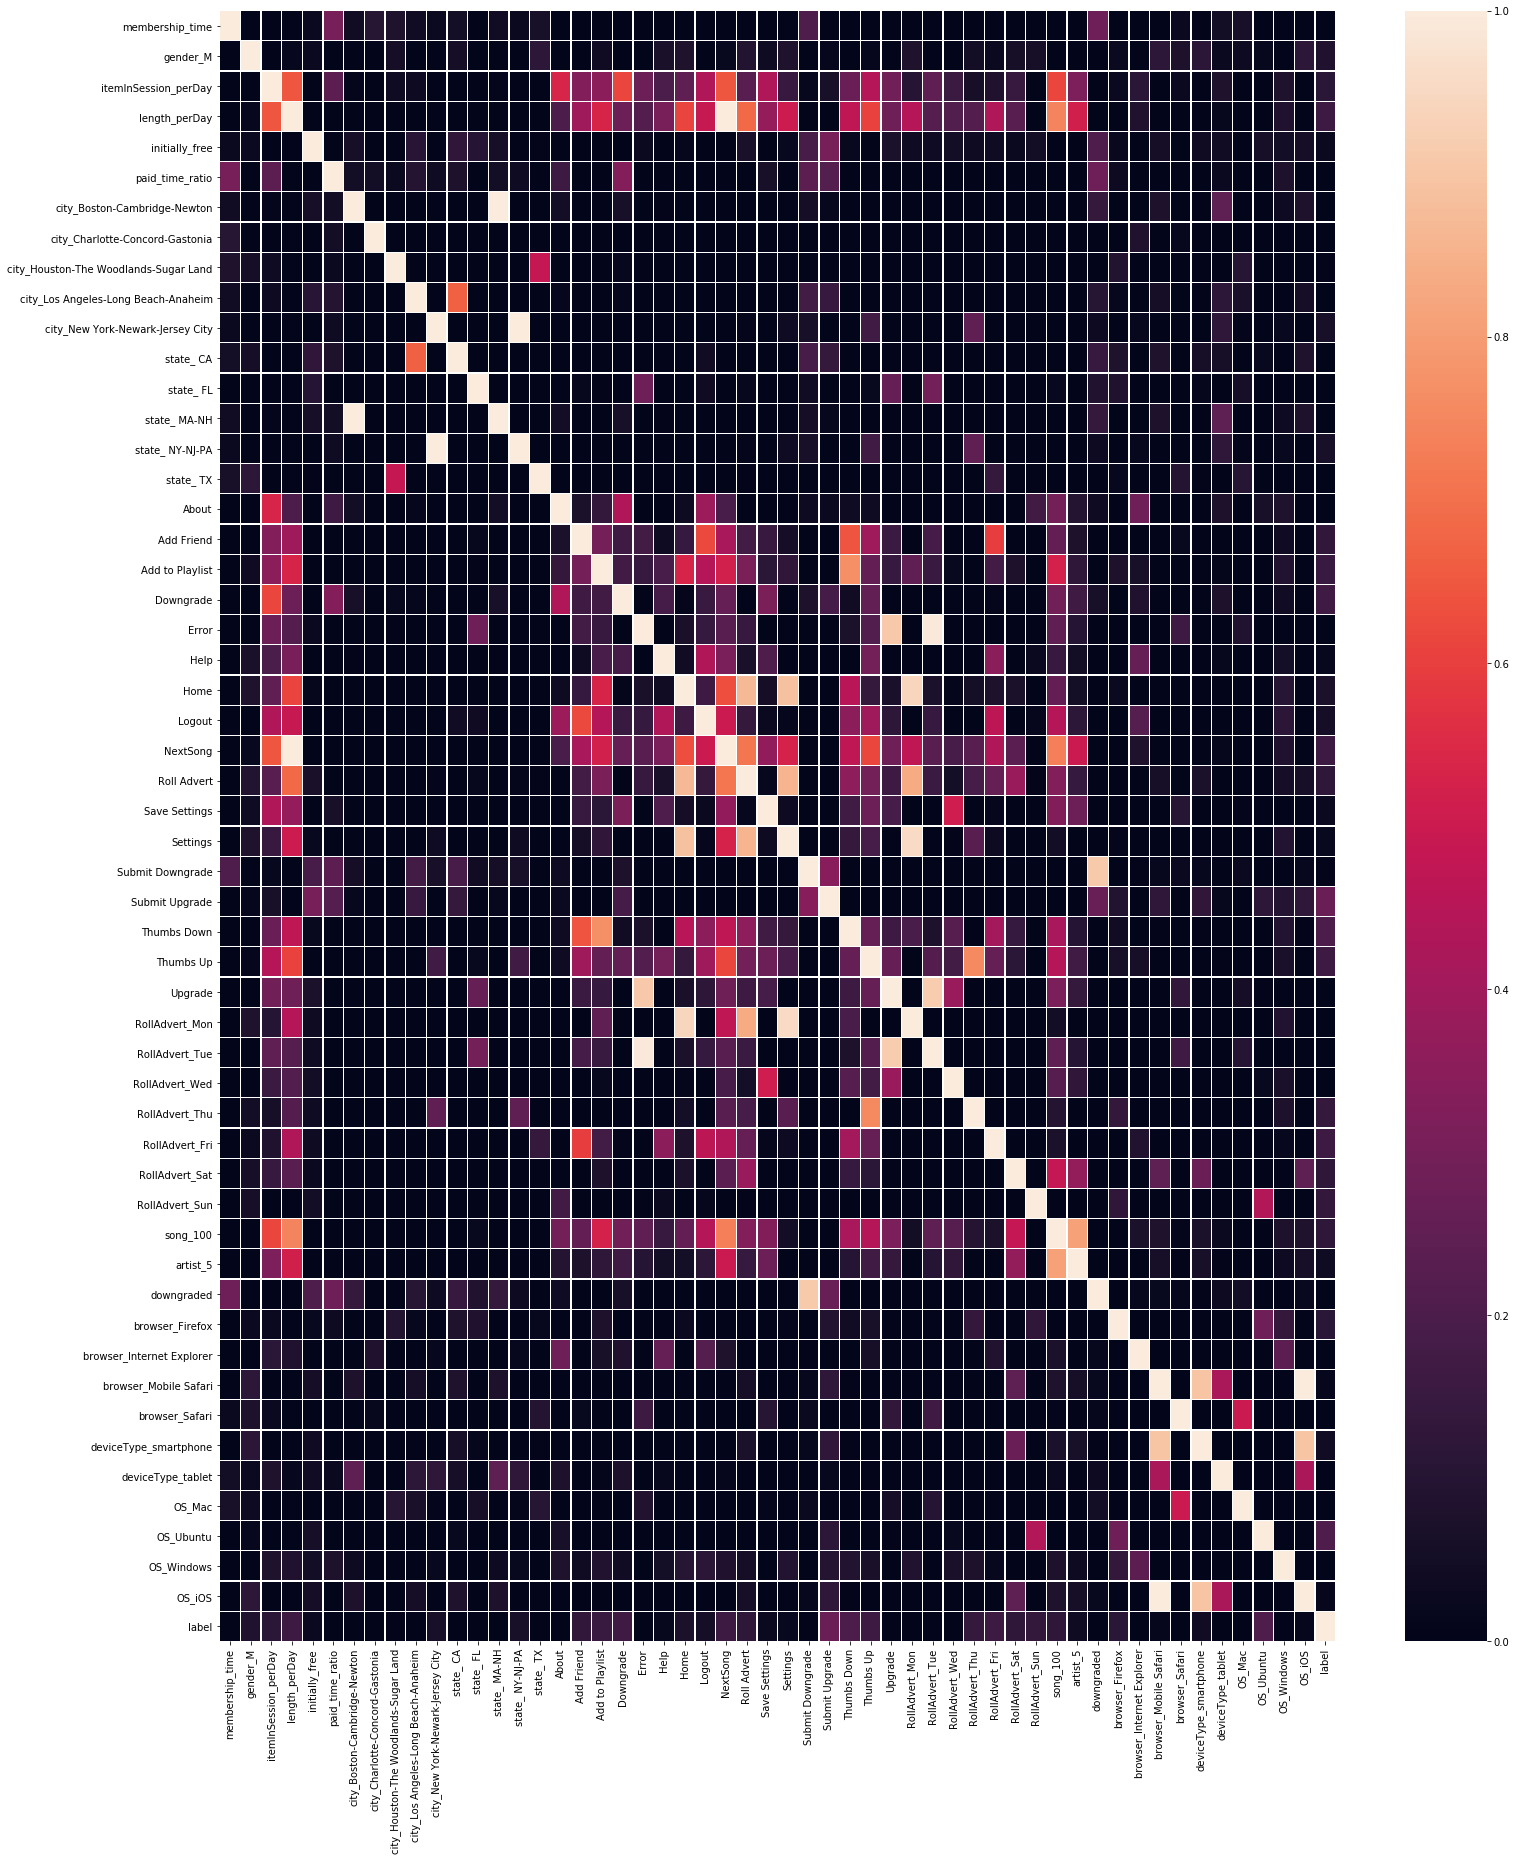

In [98]:
# HeatMap of correlations between the features
plt.subplots(figsize=(25,30))
sns.heatmap(dfp_final.corr(), linewidth=.2, vmin=0., vmax=1);

A heatmap of the final dataframe is shown above (since the correlation between the label(churn) column and the features is desired, the maximum and minimum heatmap values are set to 0.3 and 0, respectively, to have more clear view - one can easily set these values to 1 and 0).

# 4. Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

## 4.1. Split the dataset to train and test sets

In [99]:
## Split data to train and test sets
def split_dataset(dataset, train_size= 0.7, seed=42):
    """
    This function splits a pyspark dataframe to train and test sets
    
    Inputs: 
        dataset: dataframe to be splitted
        train_size: number between 0. and 1.
        seed: the seed for sampling
    Outputs:
        train and test dataframes
    """
    test_size = 1 - train_size
    train, test = dataset.randomSplit([train_size, test_size], seed)
    return train, test


## 4.2. Crearing the pipeline with scaled vector of features

[VectorAssembler](https://spark.apache.org/docs/3.1.3/api/python/reference/api/pyspark.ml.feature.VectorAssembler.html) is a feature transformer that merges multiple columns into a vector column.

[StandardScaler](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StandardScaler.html) standardizes features by removing the mean and scaling to unit variance using column summary statistics on the samples in the training set (since the units of the features are different, StandardScaler is used rather than Normalizer in order to to scale all the features of the dataset to have the same scale).

Since the binary features are either 1 or 0, only the non-binary features are scaled.


In [100]:
def build_pipeline(classifier):
    """
    This function builds the pipeline for cross-validation
    
    Input:
        classifier: the ML classifier
    Output:
        pipeline object
    """
    
    # Vectorizing and scaling nonBinary features
    assembler_nonBinary = VectorAssembler(inputCols=non_binary_features, 
                                          outputCol="nonBinaryFeatures")
    
    scaler_nonBinary = StandardScaler(inputCol="nonBinaryFeatures", 
                                      outputCol="nonBinaryFeaturesScaled")
    
    # Vectorizing all features
    assembler_total = VectorAssembler(inputCols=binary_features+["nonBinaryFeaturesScaled"], 
                                      outputCol="features")

    ## steps that will be used for the pipeline
    steps = [assembler_nonBinary, scaler_nonBinary, assembler_total, classifier]

    pipeline = Pipeline(stages = steps)
    
    return pipeline    

## 4.3. Building the classifiers model and performing cross-validation

 Apache Spark [MLlib](https://spark.apache.org/mllib/) has several [classification methods](https://spark.apache.org/docs/latest/ml-classification-regression.html#classification) that can handle with big-data models efficiently. Here, four popular algorithms of Random Forest, Gradient Boosted Trees Clssifier, Logistic Regression, and Linear Support Vector Machine are utilized.

In [101]:
def define_models():
    """
    This function creates the four ML model 
    
    Input: -
    Output: 
         classifier_list: a list containing four classifier models
         parameters_list: a list containing the tunning parameters for each classifier   
    """
    ## Logistic Regression classifier
    lr_clf = LogisticRegression()
    lr_clf.name_ = 'LogisticRegression'
    ## Tunning parameters for Logistic Regression
    para_lr = ParamGridBuilder() \
        .addGrid(lr_clf.maxIter, [5, 10, 50]) \
        .addGrid(lr_clf.regParam, [0, 0.1, 0.2]) \
        .build()

    ## Random Forest classifier
    rf_clf = RandomForestClassifier(seed=10)
    rf_clf.name_ = 'RandomForest'
    ## Tunning parameters for Random Forest
    para_rf = ParamGridBuilder() \
                .addGrid(rf_clf.numTrees, [3, 10, 30]) \
                .addGrid(rf_clf.maxDepth, [5, 10, 20]) \
                .build()

    ## Gradient Boosted Trees classifier
    gbt_clf = GBTClassifier(seed=10)
    gbt_clf.name_ = 'GradientBoostedTreesClassifier'
    ## Tunning parameters for Gradient Boosted Trees
    para_gbt = ParamGridBuilder() \
                .addGrid(gbt_clf.maxIter, [5, 10, 50]) \
                .addGrid(gbt_clf.maxDepth, [3, 10, 20]) \
                .build()

    ## Linear Support Vector Machine classifier
    svc_clf =LinearSVC()
    svc_clf.name_ = 'LinearSVC'
    # Tunning parameters for Linear Support Vector Machine
    para_svc = ParamGridBuilder() \
                .addGrid(svc_clf.maxIter, [5, 10, 50]) \
                .addGrid(svc_clf.regParam, [0, 0.1, 0.2]) \
                .build()

    ## create a list of the classifiers
    classifier_list = [lr_clf, rf_clf, gbt_clf, svc_clf]
    parameters_list = [para_lr, para_rf, para_gbt, para_svc]
    
    
    return classifier_list, parameters_list
    
    

In [102]:
def fit_model(training_data, classifier, parameters, seed, numFolds):
    """
    This function fits the model on the training dataset using the 
    created pipeline and input tunning parameters
    
    Input:
        training_data: trining dataset (sparkify dataframe)
        classifier: the classifier for creating the pipeline
        parameters: tunning parameters created using ParamGridBuilder()
        seed: seed value (integer)
        numFolds: number of folds for cross-validation (integer)
        
    Outputs:
        model_cv: trained model
        grid: dataframe containing the scores for each hyper-parameter
        
    """
   
    print('\n\n----------------------- Starting the {} Model -----------------------'. format(classifier.name_))
    print('Building the pipeline for {} model ...'.format(classifier.name_))
    
    pipeline = build_pipeline(classifier) # create the pipeline
    
    # create corssValidator object
    cv = CrossValidator(estimator=pipeline,
                        estimatorParamMaps=parameters,
                        evaluator=MulticlassClassificationEvaluator(metricName = 'f1'),
                        numFolds=numFolds,
                        seed=seed)
    
    print('Training {} model ...'.format(classifier.name_))
    t_start = time.time() # time at the beginning of fitting
    model_cv = cv.fit(training_data) # fit the model
    t_end = time.time()  # time at the end of fitting

    # Model parameters and scores
    paras = model_cv.getEstimatorParamMaps()
    parametes_name = [key.name for key in paras[0]]
    grid = pd.DataFrame([list(ele.values()) for ele in paras], 
                        columns = parametes_name)
    grid['score'] = model_cv.avgMetrics

    model_cv.name_clf = classifier.name_ # name of the classifier
    model_cv.time = round((t_end - t_start), 2) # calculation time of the pipeline
    model_cv.paraGridSize= grid.shape[0] # totla number of grid-search points
    # Information of the model wih best score
    model_cv.bestModelInfo = grid[grid['score']==grid['score'].max()].to_dict('records')
    
    print('Trianing {} model is completed.'.format(classifier.name_))
    print('Total calculation time: %.2f seconds' % model_cv.time)
    print('Size of the grid-search: %d' % model_cv.paraGridSize)
    print('Best parameters and score:')
    print(model_cv.bestModelInfo)
    print(grid)
  
    return model_cv

In [103]:
def perform_cross_validation(train):
    """
    This function creates four ML classifier models for cross-validation
    
    Inputs: -
    Outputs: 
        models_trained: list of traied models
    """
    
    # get the classifier objects and tunning parameters
    classifier_list, parameters_list = define_models()
    
    ## create empty lists to store models objects
    models_trained = []

    ## fitting the models
    for classifier, parameters in zip(classifier_list, parameters_list):
        model_trained = fit_model(train, classifier, parameters, seed=42, numFolds=4)
        models_trained.append(model_trained)

    print('\n==================== Cross-validation is finished ============================\n')

    return models_trained


In [104]:
def best_models_metrics(models_trained):
    """
    This function finds the best model from cross-validation and
    prints the best score for each model
    
    Inputs: 
        models_trained: the trained models obtained from cross-validation step
    
    Output:
        best_model: the best model object, which will be used on the test set
    """
    
    # empty lists to store info
    model_name = []
    model_score = []
    model_time = []
    model_paras = []
    
    best_score = 0.
    best_time = 1e9
    for model in models_trained:
        model_name.append(model.name_clf) # model name
        model_time.append(model.time) # calculation time
        model_score.append(model.bestModelInfo[0]['score']) # model score
        
        # compact the model parameters into one string for better view
        parametes_name = [key.name for key in model.getEstimatorParamMaps()[0]]
        s = ''
        for para in parametes_name:
            s += para + ':' + str(model.bestModelInfo[0][para]) + ' '
        model_paras.append(s.strip())

        ## find the best model
        if model.bestModelInfo[0]['score']>=best_score and model.time<best_time:
            best_score = model.bestModelInfo[0]['score']
            best_time = model.time
            best_model = model
        
    # create metric dataframe
    d = {'model name':model_name, 
         'calculation time':model_time,  
         'best parameters':model_paras,
         'best score':model_score}
    model_df = pd.DataFrame(data=d)
    model_df.sort_values(by=['best score', 'calculation time'],
               ascending=[False, True])
    
    print('\n\n ========================= Finding the best model =========================')
    print(model_df)
    print('\nBest model is %s with calculation time of %.2f seconds and training score of %.4f' % \
          (best_model.name_clf, best_time, best_score))

    return best_model


In [105]:
def evaluate_best_model_performance(test, best_model):
    """
    This function evaluates performance of the best model on the test dataset
    
    Inputs:
        test: test dataset (spark dataframe)
        best_model: best model (ML model)
        
    Outputs: None (printed results)
    """

    ## Best model predictions on the test set
    predictions = best_model.transform(test)

    # evaluate its performance
    evaluator = MulticlassClassificationEvaluator(metricName = 'f1')
    test_f1_score = evaluator.evaluate(predictions) # calculate f1_score

    # calculate total number of churn and active users in the test and prediction
    test_churn = predictions.select('label').where(predictions.label==1).count()
    test_active = predictions.select('label').where(predictions.label==0).count()
    tot =  predictions.select('label').count()
    pred_churn = predictions.select('prediction').where(predictions.prediction==1).count()
    pred_active = predictions.select('prediction').where(predictions.prediction==0).count()

    # print the results
    print('\n\n============== Evaluate performance of the best model on the test dataset ==============')
    print("\nThe F1 score on the test data is {:.4f}\n".format(test_f1_score))

    predictions.select('label','prediction').show(100)


In [106]:
def plot_feature_importance(best_model):
    """
    This function plots the importance of the features (if the ML model is RandomForest)
    input:
        best_model: the best model object     
    Output: none (figures)
    """

    bm = best_model.bestModel
    features = non_binary_features+ binary_features
    feature_importance = pd.Series(bm.stages[-1].featureImportances, index=features)

    large20 =  feature_importance.nlargest(20).tolist()
    large20_index =  feature_importance.nlargest(20).index.tolist()
    smallest35 = feature_importance.nsmallest(33).tolist()
    smallest35_index =  feature_importance.nsmallest(33).index.tolist()

    ## plot
    fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(15, 15))
    # fig.suptitle('Feature Importance', fontsize=16)

    ## Subplot 1 
    barWidth = 0.8
    br1 = np.arange(len(large20)) 
    br2 = np.arange(len(smallest35)) 

    axs[0].bar(br1, large20, color ='b', width = barWidth)
    axs[0].set_ylabel('Relative importance', fontsize = 18)
    axs[0].set_xticks([r for r in range(len(large20))])
    axs[0].set_xticklabels(large20_index, rotation=90, fontsize=14)
    axs[0].set_title('20 most important features (total number of feature=53)', fontsize=20);


    axs[1].bar(br2, smallest35, color ='b', width = barWidth)
    axs[1].set_ylabel('Relative importance', fontsize = 18)
    axs[1].set_xticks([r for r in range(len(smallest35))])
    axs[1].set_xticklabels(smallest35_index, rotation=90, fontsize=14)
    axs[1].set_title('33 least important features (total number of feature=53)', fontsize=20);

    plt.subplots_adjust(left=0.,
                        bottom=0.,
                        right=1.,
                        top=1.,
                        hspace=0.8)
    plt.show()
   

Train set: rows: 161 	, columns: 54
Test set: rows: 64 	, columns: 54
--------------------------------------------------------------------------



----------------------- Starting the LogisticRegression Model -----------------------
Building the pipeline for LogisticRegression model ...
Training LogisticRegression model ...
Trianing LogisticRegression model is completed.
Total calculation time: 362.14 seconds
Size of the grid-search: 9
Best parameters and score:
[{'maxIter': 10.0, 'regParam': 0.0, 'score': 0.80576627994788763}]
   maxIter  regParam     score
0        5       0.0  0.733396
1        5       0.1  0.764284
2        5       0.2  0.769433
3       10       0.0  0.805766
4       10       0.1  0.766711
5       10       0.2  0.765633
6       50       0.0  0.702561
7       50       0.1  0.770475
8       50       0.2  0.765633


----------------------- Starting the RandomForest Model -----------------------
Building the pipeline for RandomForest model ...
Training RandomForest mo

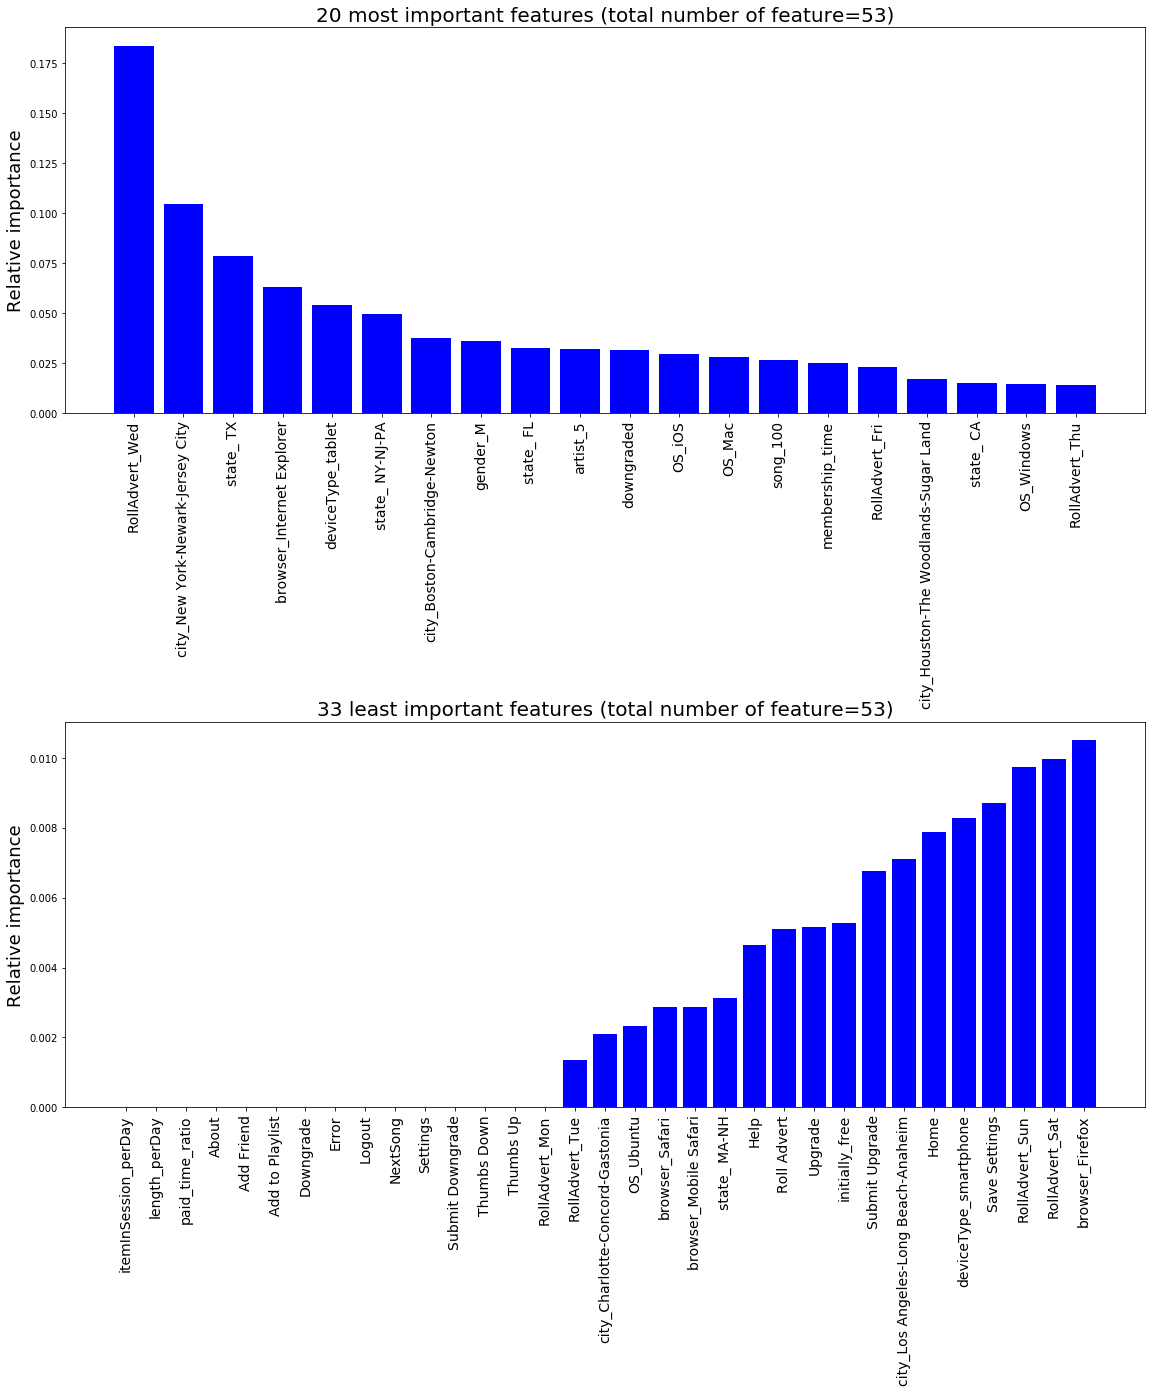

In [107]:
def modeling_main(dfs):
    
    """
    This function performs all the modeling steps including spliting the dataset,
    building pipelines with different classifier models, perfroming cross-validation,
    finding the best model, and evaluating the best model's performance on the test dataset
    
    Input: 
        dfs: the final user-item dataset which includes different features
             for each user (spark dataframe)
             
    Output: Training scores, calculation time, and best model performance
    """
    
    train, test = split_dataset(dfs, train_size= 0.75, seed=42)
    print('Train set: rows: %d \t, columns: %d' % (train.count() , len(train.columns)))
    print('Test set: rows: %d \t, columns: %d' % (test.count() , len(test.columns)))
    print('--------------------------------------------------------------------------\n')
    
    
    # split the dataset to train and test sets
    train, test = split_dataset(dfs, train_size= 0.75, seed=42)
    
    # perform cross-validation 
    models_trained = perform_cross_validation(train)
    
    # find the best model
    best_model = best_models_metrics(models_trained)
    
    # calculate the best models performance on the test dataset
    evaluate_best_model_performance(test, best_model)
    
    # plot the importance of features (only for Random Forest model)
    if 'Forest' in best_model.name_clf:
        plot_feature_importance(best_model) 
        


modeling_main(dfs)   

# 5. Conclusion

In this capstone project a mini-datset (128 Megabytes) of users interaction with Sparkify (imaginary) app is used to perform churn analysis. First, the datset is cleansed and exploratory data analysis is perfomed in details to find proper features. The final dataset had 225 rows (number of users) and 54 columns. Four different classification algorithms are considered and cross-validation is performed for all of them. The best model is found and its performance seems promising.

### Performance on the training dataset:
From the above outputs, it is clear that Random Forest yields the best training scores of ~ 0.814 with smallest calculation time of ~ 333 seconds (all models have 3*3 parameters grid size).

### Performance on the test dataset:
It can be seen that Random Forest can predict the churn users with F1-score of 0.81. This can be considered reasonable.



###  Discussions:

It's important to acknowledge that in your current mini-dataset, the skewness is relatively low, with 52 churned users out of a total of 225 users. However, when dealing with a larger dataset, especially one as substantial as 12 gigabytes, there is a greater likelihood of encountering skewness, which can indeed have a significant impact on the performance of machine learning models. Addressing data skewness is a crucial consideration in machine learning, as it can lead to biased model predictions. To mitigate this, various techniques such as oversampling the minority class, undersampling the majority class, or using different evaluation metrics that are less sensitive to class imbalance can be explored. Additionally, more advanced models designed to handle imbalanced datasets, like cost-sensitive classifiers or ensemble methods, may be beneficial in such scenarios.


It should be noted that the binary features are not scaled here, and it might have positive impact on the model perfomance. However, using reasonable and appropriate features is the most significant factor:


Interestingly, it appears that the weekday for the advertisement event ranks as the most crucial feature. Following that, the most significant features include city, state, browser, device type, gender, the top five most popular artists, and so on. Although providing advices based on this mini-dataset is not reasonable, it seems that showing less advertisement can entice users to stay active. 

### Future work and possible improvements:

For the future work, the most important step is to use the big dataset and run the models on [Amazon Web Services](https://aws.amazon.com/) (AWS) clusters. In additon, more tunning-parameters can be used if the results are not promising. I will also considere removing less important features (according to the feature-importance figure) to reduce the calculation time and keep the computational resources for more important tasks.  

# 6. Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.